In [370]:
import os
import re
import numpy as np
from numpy import linalg as LA
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt 
from time import gmtime, strftime
from scipy.signal import butter, lfilter,savgol_filter
#from_future_import division
import scipy as sp

In [371]:
def dataseparation(flocation):
    '''
    this function change the log.file into dataframe form
    
    input: fname: log file location
    
    output: DataFrame
    '''
    #title_akas = pd.read_csv('/Users/seankamano/Downloads/title.akas.tsv', delimiter = '\t', encoding = 'utf-8')
    f_1 = open(flocation, 'r') # read files
    lines = f_1.readlines() # read line by line
    f_1.close() # close the file
    new_lines = []
    for l in lines:
        new_lines.append(l.split('\t')) # remove "\t" by line
    
    mHealth = pd.DataFrame(new_lines)
    return mHealth


def getsubject(dataFrame):
    '''
    input: dataFrame of dataseparation
    output: ECG1, ECG2
            acceleration ax, ay, az
            acceleration a = sqrt( ax^2 + ay^2 + az^2  
            activity label = 1,2,...12
    '''
    ECG1 = pd.to_numeric(dataFrame[3])
    ECG2 = pd.to_numeric(dataFrame[4])
    ax = pd.to_numeric(dataFrame[0])
    ay = pd.to_numeric(dataFrame[1])
    az = pd.to_numeric(dataFrame[2])
    a = np.sqrt(ax**2 + ay**2 + az**2)
    label = pd.to_numeric(dataFrame[23])
    return ECG1, ECG2, ax, ay, az, a, label


def bandpass_filter(data, signal_freq = 50, lowcut = 0.0001, highcut = 3.0, filter_order = 1):
    '''
    this function is to apply butterworth filter
    input: raw data
           float lowcut
           float highcut
           int signal frequency in samples per second
           filter order
    output: filtered data
    '''
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype = "band")
    y = lfilter(b, a, data)
    return y


def findpeaks(data, spacing=10, limit = 0.01):
        """
        Janko Slavic peak detection algorithm and implementation.
        https://github.com/jankoslavic/py-tools/tree/master/findpeaks
        Finds peaks in `data` which are of `spacing` width and >=`limit`.
        :param ndarray data: data
        :param float spacing: minimum spacing to the next peak (should be 1 or more)
        :param float limit: peaks should have value greater or equal
        :return array: detected peaks indexes array
        """
        len = data.size
        x = np.zeros(len + 2 * spacing)
        x[:spacing] = data[0] - 1.e-6
        x[-spacing:] = data[-1] - 1.e-6
        x[spacing:spacing + len] = data
        peak_candidate = np.zeros(len)
        peak_candidate[:] = True
        for s in range(spacing):
            start = spacing - s - 1
            h_b = x[start: start + len]  # before
            start = spacing
            h_c = x[start: start + len]  # central
            start = spacing + s + 1
            h_a = x[start: start + len]  # after
            peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))

        ind = np.argwhere(peak_candidate)
        ind = ind.reshape(ind.size)
        if limit is not None:
            ind = ind[data[ind] > limit]
        return ind
    
    
def detect_peaks(data):
    """
    extracting peaks from loaded ECG measurements data through measurements processing
    input: raw data
    output: peak indices
    """
        # Extract measurements from loaded ECG data.
    ecg_measurements = data

        # Measurements filtering - 0-15 Hz band pass filter.
    filtered_ecg_measurements = bandpass_filter(ecg_measurements)
        #self.filtered_ecg_measurements[:5] = self.filtered_ecg_measurements[5]

        # Derivative - provides QRS slope information.
    differentiated_ecg_measurements = np.ediff1d(filtered_ecg_measurements)

        # Squaring - intensifies values received in derivative.
    squared_ecg_measurements = differentiated_ecg_measurements ** 2

        # Moving-window integration.
    integration_window = 3
    integrated_ecg_measurements = np.convolve(squared_ecg_measurements, np.ones(integration_window))

        # Fiducial mark - peak detection on integrated measurements.
    detected_peaks_indices = findpeaks(data=integrated_ecg_measurements)

    detected_peaks_values = integrated_ecg_measurements[detected_peaks_indices]
    
    return detected_peaks_indices, detected_peaks_values


def ecg2bpm(detected_peaks_indices):
    '''
    this function converts ecg to bpm
    input: detected peaks indices from qrs_detected_indices
    output: peaks_indice and BPM
    '''
    m = 0
    BPM = np.array([])
    time = np.array([])
    count = 1
    for i in detected_peaks_indices[1:]:
        RR_interval = (i - m) # peak-peak intervals
        m_distance = RR_interval / 50.*1000 # calculate the ms distance
        m = i
        bpm = 60000. / m_distance
        #time = np.append(time, (i + m) / 2.)
        time = np.append(time, i)
        if count > 1 and abs(bpm - BPM[-1]) > 60 :
            bpm = BPM[-1]
        BPM = np.append(BPM, bpm)
        count = count + 1
    return time, BPM


def detect_qrs(data, detected_peaks_indices, detected_peaks_values):
        """
        Method responsible for classifying detected ECG measurements peaks either as noise or as QRS complex (heart beat).
        input: raw data, detected_peaks_indices and corresponding valus
        output: qrs_peaks_indices, noise_peaks_indices
        
        """
        refractory_period = 12#24  # Change proportionally when adjusting frequency (in samples).
        qrs_peak_filtering_factor = 0.125
        noise_peak_filtering_factor = 0.125
        qrs_noise_diff_weight = 0.25
        
        qrs_peak_value = 0.0
        noise_peak_value = 0.0
        threshold_value = 0.0
        
        # Detection results.
        qrs_peaks_indices = np.array([], dtype=int)
        noise_peaks_indices = np.array([], dtype=int)

        # Final ECG data and QRS detection results array - samples with detected QRS are marked with 1 value.
        ecg_data_detected = None

        for detected_peak_index, detected_peaks_value in zip(detected_peaks_indices, detected_peaks_values):

            try:
                last_qrs_index = qrs_peaks_indices[-1]
            except IndexError:
                last_qrs_index = 0

            # After a valid QRS complex detection, there is a 200 ms refractory period before next one can be detected.
            if detected_peak_index - last_qrs_index > refractory_period or not qrs_peaks_indices.size:
                # Peak must be classified either as a noise peak or a QRS peak.
                # To be classified as a QRS peak it must exceed dynamically set threshold value.
                if detected_peaks_value > threshold_value:
                    qrs_peaks_indices = np.append(qrs_peaks_indices, detected_peak_index)

                    # Adjust QRS peak value used later for setting QRS-noise threshold.
                    qrs_peak_value = qrs_peak_filtering_factor * detected_peaks_value + \
                                          (1 - qrs_peak_filtering_factor) * qrs_peak_value
                else:
                    noise_peaks_indices = np.append(noise_peaks_indices, detected_peak_index)

                    # Adjust noise peak value used later for setting QRS-noise threshold.
                    noise_peak_value = noise_peak_filtering_factor * detected_peaks_value + \
                                            (1 - noise_peak_filtering_factor) * noise_peak_value

                # Adjust QRS-noise threshold value based on previously detected QRS or noise peaks value.
                threshold_value = noise_peak_value + \
                                       qrs_noise_diff_weight * (qrs_peak_value - noise_peak_value)

        # Create array containing both input ECG measurements data and QRS detection indication column.
        # We mark QRS detection with '1' flag in 'qrs_detected' log column ('0' otherwise).
        measurement_qrs_detection_flag = np.zeros([len(data), 1])
        measurement_qrs_detection_flag[qrs_peaks_indices] = 1
        ecg_data_detected_ = np.append(data, measurement_qrs_detection_flag)
        ecg_data_detected = np.append(ecg_data_detected_, 1)
        
        #return measurement_qrs_detection_flag
        #return ecg_data_detected
        return qrs_peaks_indices, noise_peaks_indices
    
def activitylevel(acc):
    '''
    input: param: acc type: narray acceleration values
    output: activity level using equation sqrt(delt_a**2 + delt_t**2)
            since the sampling rate is 50 Hz, we would like to obtain the activity level 
            withini a second, considering 50 samples at a time and only caring about the 
            differences in acceleration and time in a short period
    
    '''
    n = 0
    act_level = np.array([])
    time = np.array([]) # store the indices
    while n < len(acc)-50:
        delt_sum = 0
        for i in range(25):
            delta = acc[n + (i+1) * 2] - acc[n + 2*i]
            deltt = 5 * 0.02 
            delt_sum = np.sqrt(delta**2 + deltt**2) + delt_sum
   
        act_level = np.append(act_level, delt_sum)
        time = np.append(time, n )
        n = n + 50
        
    return act_level, time


def activitylevel2(acc):
    '''
    input: param: acc type: narray acceleration values
    output: activity level using equation sqrt(delt_a**2 + delt_t**2)
            since the sampling rate is 50 Hz, we would like to obtain the activity level 
            withini a second, considering 50 samples at a time and only caring about the 
            differences in acceleration and time in a short period
    
    '''
    n = 0
    act_level = np.array([])
    while n < len(acc)-50:
        delt_sum = 0
        deltt = 5 * 0.02
        delta = acc[n + 50] - acc[n]
        delt_sum = np.sqrt(delta**2 + deltt**2) 
   
        act_level = np.append(act_level, delt_sum)
        n = n + 50
        
    return act_level



In [372]:
def activitylevel3(acc):
    '''
    input: param: acc type: narray acceleration values
    output: activity level using equation sqrt(delt_a**2 + delt_t**2)
            since the sampling rate is 50 Hz, we would like to obtain the activity level 
            withini a second, considering 50 samples at a time and only caring about the 
            differences in acceleration and time in a short period
    
    '''
    '''
    n = 0
    act_level = np.array([])
    while n < len(acc)-50:
        delta = acc[n: n+50].mean()
        act_level = np.append(act_level, delta)
        n = n + 50
    return act_level
    '''
    freq = len(acc)/50
    al = []
    for i in range(freq):
        delta = acc[i*50:(i+1)*50].mean()
        al.append(delta)
    return al


    
    

In [373]:
def BPM_slidewindow(ecg):
    ecgtest = ECG1[10000:70000]
    ECG=ecgtest.tolist()
    listBPM = [];
    k = 0
    while k < len(ECG) - 2999 :
        et = ECG[k : k + 2999]
        for i in range(59):
            eb=et[50*i:50*(i+2)]
            MAX=max(eb)
            MIN=min(eb)
            TH=MIN+5*(MAX-MIN)/10
            flag1=0
            flag2=0
            for j in range(len(eb)):
                if(eb[j]>TH):
                    if(flag1==0):
                        tmp1=j
                        flag1=1
                    elif (flag2==0 and j-tmp1>14):
                        tmp2=j
                        flag2=1
            deltat=tmp2-tmp1
            bpm=60./(deltat/50.)
            listBPM.append(bpm)
        
        k = k + 3000
        listBPM.append(listBPM[-1])
    return listBPM

# Testing

In [374]:
filelocation = "/Users/huangzhisheng/Desktop/ECE251B/project/MHEALTHDATASET/mHealth_subject6.log"
mHealth = dataseparation(filelocation)
ECG1, ECG2, ax, ay, az, a, label= getsubject(mHealth)

In [375]:
'''this line is to count the whole time
    len(ECG1)=122112
    whole time is 40.7min
    For the whole picture, I only use data of first 12 mins.
'''

'this line is to count the whole time\n    len(ECG1)=122112\n    whole time is 40.7min\n    For the whole picture, I only use data of first 12 mins.\n'

In [376]:
label_1 = np.where(label == 1) # samples for L1 label
label_2 = np.where(label == 2)
label_3 = np.where(label == 3)
label_4 = np.where(label == 4)
label_5 = np.where(label == 5)
label_6 = np.where(label == 6)
label_7 = np.where(label == 7)
label_8 = np.where(label == 8)
label_9 = np.where(label == 9)
label_10 = np.where(label == 10)
label_11 = np.where(label == 11)
label_12 = np.where(label == 12)
print label_12[0].shape
#index for selected activities
new_index = np.concatenate([label_1[0], label_2[0], label_3[0], label_4[0], label_5[0], \
                            label_6[0], label_7[0], label_8[0], label_9[0], label_10[0],\
                            label_11[0], label_12[0]])
print new_index.shape

(1024,)
(32205,)


In [377]:
#start = 42000
#end = 54000
ecg_measurements = ECG1[new_index].values # first minute 50 points per second
acc = a[new_index].values
print len(acc)
detected_peaks_indices, detected_peaks_values = detect_peaks(ecg_measurements)

32205


In [378]:
qrs_peaks_indices, noise_peaks_indices = detect_qrs(ecg_measurements, detected_peaks_indices, detected_peaks_values)
print noise_peaks_indices.shape
time, BPM = ecg2bpm(qrs_peaks_indices)
print len(BPM), len(time)
BPM_slidingwindow = BPM_slidewindow(ecg_measurements)
act_level, t = activitylevel(acc)
print ('activity level', len(act_level))

(78,)
1016 1016
('activity level', 644)


# BPM:  (1016,)
('mean value: ', 101.76475344766503)
('largest value: ', 166.66666666666666)
('Activity Level:', (644,))


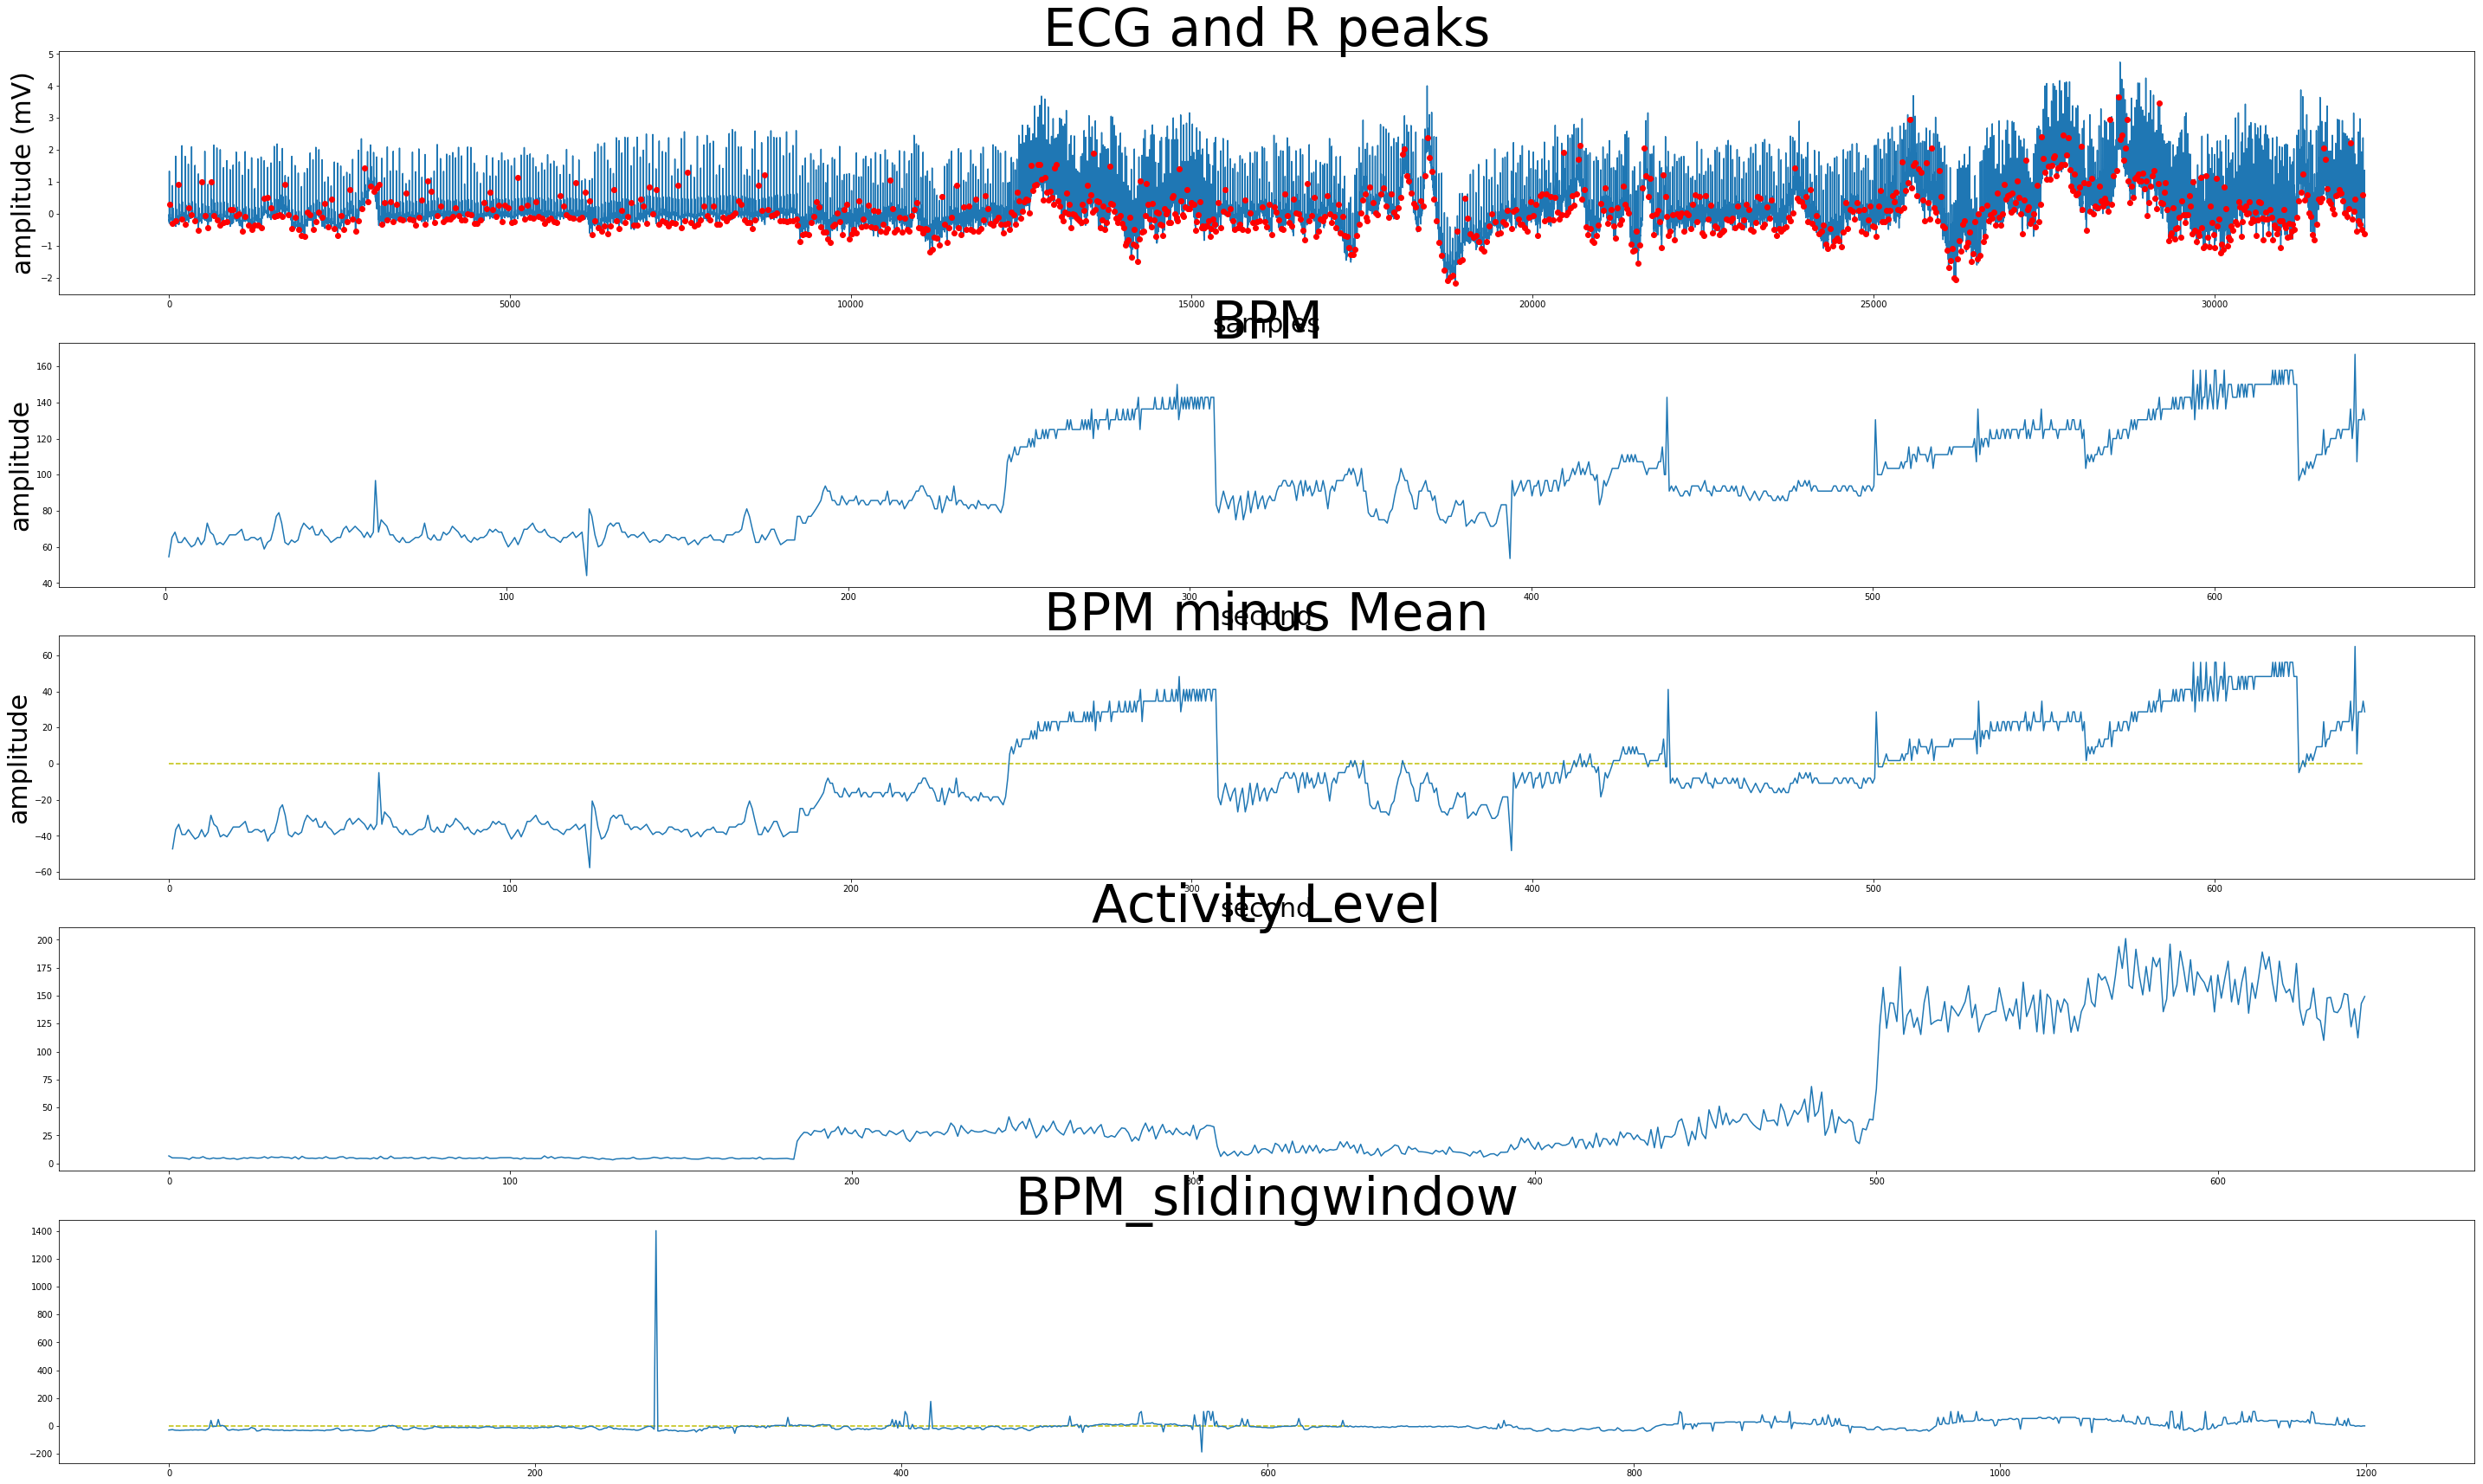

In [379]:
fig = plt.figure(figsize=(50, 30))


subplot1 = fig.add_subplot(511)
subplot2 = fig.add_subplot(512)
subplot3 = fig.add_subplot(513)
subplot4 = fig.add_subplot(514)
subplot5 = fig.add_subplot(515)

subplot1.plot(ecg_measurements)
subplot1.plot(qrs_peaks_indices, ecg_measurements[qrs_peaks_indices], 'ro' )
subplot1.set_title('ECG and R peaks', fontsize = 60)
subplot1.set_xlabel('samples', fontsize = 30)
subplot1.set_ylabel('amplitude (mV)', fontsize = 30)

subplot2.plot(time*0.02, BPM)
subplot2.set_title('BPM', fontsize = 60)
subplot2.set_xlabel('second', fontsize = 30)
subplot2.set_ylabel('amplitude', fontsize = 30)
#e = (end-start)/3000
#for i in range(0,e,1):
 #   subplot2.vlines(i*60, 0, 150, colors = "r", linestyles = "dashed")

print "# BPM: ", BPM.shape
print ("mean value: ", BPM.mean())
print ("largest value: ", BPM.max())

BPM_avg = BPM.mean()
subplot3.plot(time*0.02, BPM-BPM_avg)
subplot3.set_title('BPM minus Mean', fontsize = 60)
subplot3.set_xlabel('second', fontsize = 30)
subplot3.set_ylabel('amplitude', fontsize = 30)
#for i in range(0,e,1):
 #   subplot3.vlines(i*60, -40, 40, colors = "r", linestyles = "dashed")
subplot3.hlines(0, 0, (len(new_index))/50, colors = "y", linestyles = "dashed")

#act = az[start:end].values
#print act.shape
#print az[0::50].shape
subplot4.plot(act_level)
print ("Activity Level:", act_level.shape)
subplot4.set_title('Activity Level', fontsize = 60)
#for i in range(0,e,1):
 #   subplot4.vlines(i*60, 0, 100, colors = "r", linestyles = "dashed")
    
subplot5.plot(BPM_slidingwindow-np.mean(BPM_slidingwindow))
subplot5.set_title('BPM_slidingwindow', fontsize = 60)
subplot5.hlines(0, 0, (len(new_index))/50, colors = "y", linestyles = "dashed")



In [380]:
#def slidingwinecg2bpm(ecg):
    et = ecg
    listBPM = np.array([]);
    i = 0
    
    while i < et.shape[0] - 50:
        eb = et[50 * i : 50 * (i + 2)]
        detected_peaks_indices, detected_peaks_values = detect_peaks(eb)
        qrs_peaks_indices, noise_peaks_indices = detect_qrs(eb, detected_peaks_indices, detected_peaks_values)
        time, BPM = ecg2bpm(qrs_peaks_indices)
        bpm = BPM.mean()
        listBPM = np.append(listBPM, bpm)
    #return listBPM

IndentationError: unexpected indent (<ipython-input-380-b5dde4d9ea76>, line 2)

In [381]:
def slidingwindecg2bpm(ecg):
    #et = ecg.values
    ecg = ecg.values
    listBPM = np.array([]);
    k = 0
    while k <= len(ecg) - 2999:
        et = ecg[k : k + 2999]
        for i in range(59):
            eb = et[50 * i : 50 * (i + 2) - 1]
            detected_peaks_indices, detected_peaks_values = detect_peaks(eb)
            qrs_peaks_indices, noise_peaks_indices = detect_qrs(eb, detected_peaks_indices, detected_peaks_values)
            time, BPM = ecg2bpm(qrs_peaks_indices)
            bpm =np.median(BPM)
            #bpm = BPM.min()
            listBPM = np.append(listBPM, bpm)
            print BPM
        listBPM = np.append(listBPM, listBPM[-1])
            
        k = k + 3000
  
    return listBPM

In [382]:
def new_slidingwin(ecg): # we apply this in our project
    ecg = ecg.values
    listBPM = np.array([])
    idx = np.array([])
    k = 0
    while k <= len(ecg) - 49:
        et = ecg[k : k + 99]
        detected_peaks_indices, detected_peaks_values = detect_peaks(et)
        qrs_peaks_indices, noise_peaks_indices = detect_qrs(et, detected_peaks_indices, detected_peaks_values)
        time, BPM = ecg2bpm(qrs_peaks_indices)
        bpm =np.median(BPM)
        #bpm = BPM.min()
        listBPM = np.append(listBPM, bpm)
        idx = np.append(idx, k + 50) # save the data point @ t = 50n
        print BPM
        k = k + 50
        
    #listBPM = np.append(listBPM)
    return listBPM, idx

In [383]:
(ecg_measurements).shape[0]

32205

In [384]:
ecgtest = ECG1[new_index]
print ecgtest.shape
wind_bpm, idx = new_slidingwin(ecgtest)
print wind_bpm.shape
detected_peaks_indices, detected_peaks_values = detect_peaks(ecgtest)
qrs_peaks_indices, noise_peaks_indices = detect_qrs(ecgtest, detected_peaks_indices, detected_peaks_values)
time, BPM = ecg2bpm(qrs_peaks_indices)
print ("BPM:", BPM.shape)
print ("sliding_win BPM: ", wind_bpm.shape)

(32205,)
[ 54.54545455]
[ 58.82352941  68.18181818]
[ 66.66666667  62.5       ]
[ 69.76744186  62.5       ]
[ 34.48275862]
[ 81.08108108  62.5       ]
[ 35.29411765]
[ 60.          88.23529412]
[ 37.5]
[ 37.97468354]
[ 39.47368421]
[ 44.7761194]
[ 49.18032787]
[ 53.57142857]
[ 54.54545455]
[ 56.60377358]
[ 57.69230769  66.66666667]
[ 61.2244898   66.66666667]
[ 68.18181818  66.66666667]
[ 76.92307692  66.66666667]
[ 38.46153846]
[ 107.14285714   69.76744186]
[ 44.11764706]
[ 46.15384615]
[ 200.  200.]
[ 52.63157895]
[ 55.55555556]
[ 60.]
[ 58.82352941  65.2173913 ]
[ 61.2244898   63.82978723]
[ 65.2173913   69.76744186]
[ 76.92307692  76.92307692]
[ 107.14285714   78.94736842   78.94736842]
[  96.77419355  115.38461538]
[ 54.54545455]
[ 55.55555556  55.55555556]
[ 157.89473684  157.89473684  157.89473684]
[ 61.2244898   63.82978723]
[  65.2173913    65.2173913   107.14285714]
[ 76.92307692  73.17073171]
[ 100.           71.42857143]
[ 46.15384615]
[ 52.63157895]
[ 57.69230769  66.66666

[ 130.43478261  136.36363636  136.36363636  136.36363636]
[  76.92307692   76.92307692  136.36363636]
[  93.75        136.36363636  142.85714286  136.36363636]
[ 120.          136.36363636  150.          130.43478261]
[ 75.  75.  75.]
[  90.90909091  136.36363636  142.85714286  150.        ]
[ 115.38461538  136.36363636  142.85714286  136.36363636]
[ 157.89473684  136.36363636  142.85714286  142.85714286]
[  90.90909091  136.36363636  142.85714286  150.        ]
[ 115.38461538  136.36363636  142.85714286  136.36363636]
[ 73.17073171  73.17073171  73.17073171]
[  90.90909091  136.36363636  142.85714286  142.85714286]
[ 115.38461538  142.85714286  142.85714286  136.36363636]
[ 166.66666667  136.36363636  142.85714286  142.85714286]
[  93.75        142.85714286   83.33333333]
[ 76.92307692  78.94736842]
[ 111.11111111   85.71428571   90.90909091]
[ 111.11111111  166.66666667  166.66666667]
[ 44.7761194]
[ 57.69230769  88.23529412]
[ 83.33333333  75.        ]
[ 48.38709677  88.23529412]
[ 

[ 130.43478261  111.11111111  115.38461538  115.38461538]
[ 115.38461538  111.11111111  115.38461538]
[ 103.44827586  115.38461538  115.38461538]
[  96.77419355  115.38461538  115.38461538]
[  90.90909091  115.38461538  115.38461538]
[  85.71428571  115.38461538  115.38461538]
[  81.08108108  115.38461538  115.38461538]
[  76.92307692  115.38461538  120.        ]
[  75.          107.14285714  136.36363636]
[ 166.66666667  136.36363636  111.11111111  120.        ]
[  71.42857143  115.38461538  120.        ]
[  69.76744186  120.          115.38461538]
[  68.18181818  125.          120.        ]
[  69.76744186  120.          120.        ]
[  69.76744186  125.          120.        ]
[ 176.47058824  120.          120.          125.        ]
[  73.17073171  125.          120.        ]
[  75.  125.  125.]
[  78.94736842  120.          125.        ]
[  81.08108108  125.          125.        ]
[  85.71428571  125.          120.        ]
[  88.23529412  125.          125.        ]
[  93.75      

In [385]:
print len(wind_bpm)

644


In [386]:
def smooth(y, box_points):
    '''
    a moving average box (by convolution) to smooth the data
    used to smooth window_bpm and activity level
    '''
    box = np.ones(box_points)/box_points
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [387]:
smooth_window_bpm = smooth(wind_bpm, 10)
smooth_act_level = smooth(act_level, 10)
print len(smooth_act_level)

644


('mean window bpm', 95.787272228299699)
('mean bpm', 101.76475344766503)
('Activity Level:', (644,))


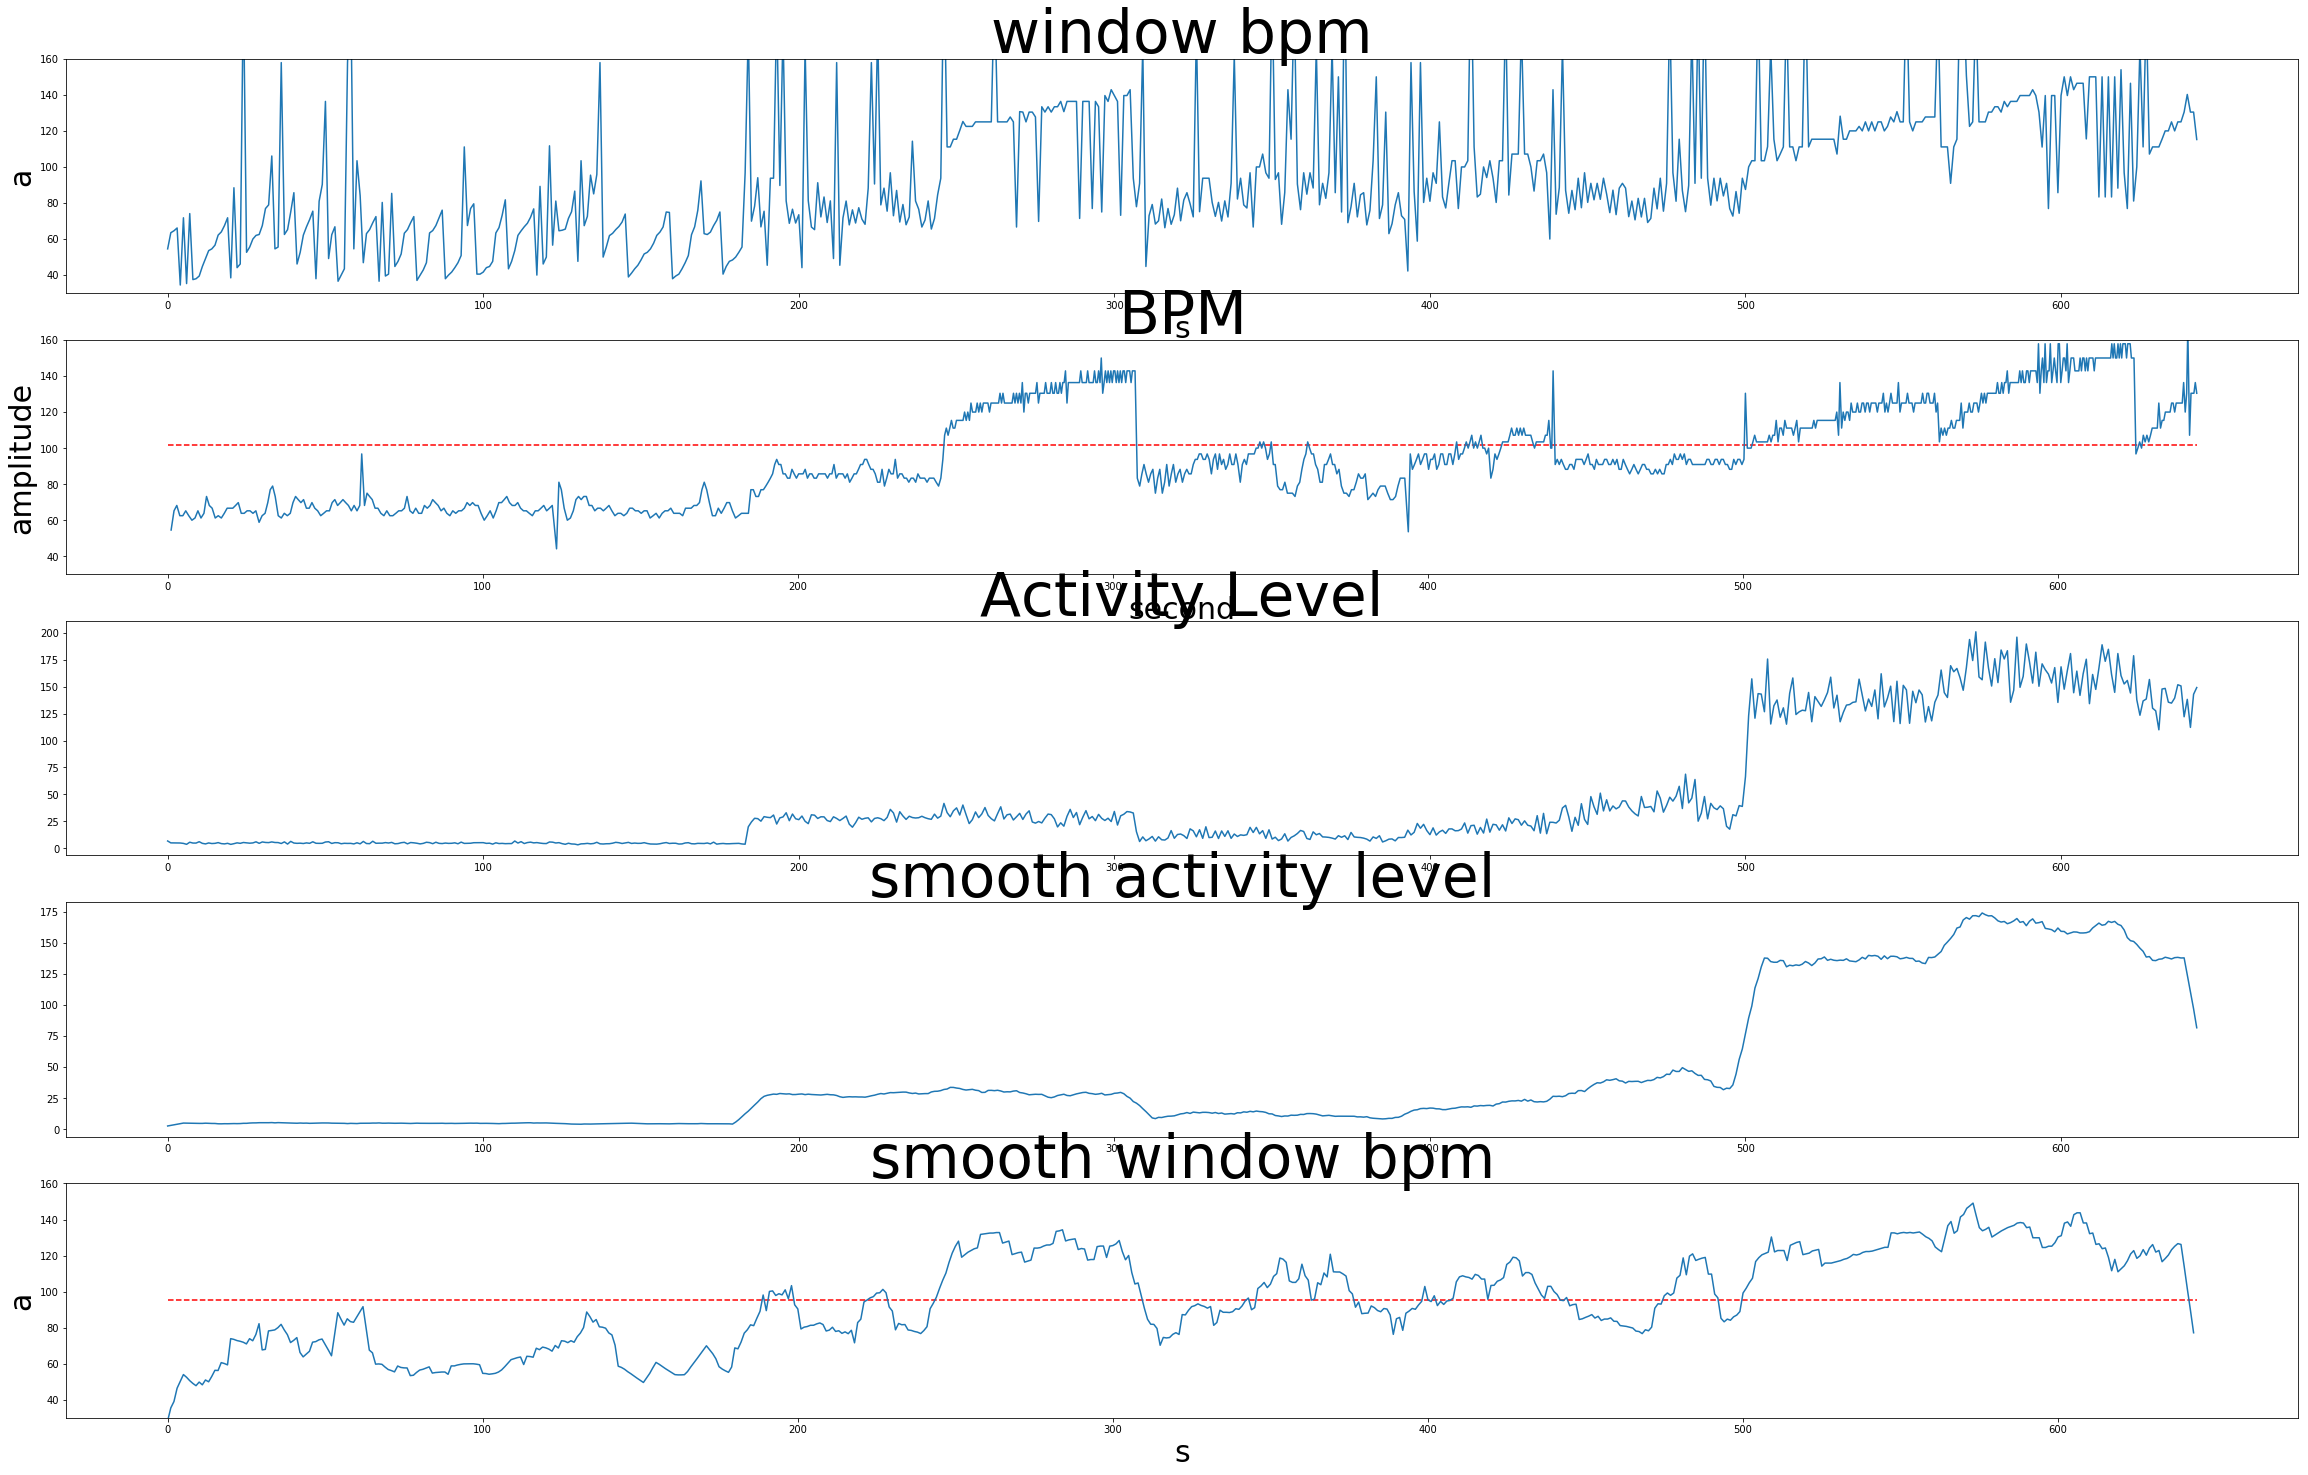

In [388]:
fig = plt.figure(figsize=(40, 25))

subplot1 = fig.add_subplot(511)
subplot2 = fig.add_subplot(512)
subplot3 = fig.add_subplot(513)
subplot4 = fig.add_subplot(514)
subplot5 = fig.add_subplot(515)

subplot1.plot(wind_bpm)
subplot1.set_title('window bpm', fontsize = 60)
subplot1.set_xlabel('s', fontsize = 30)
subplot1.set_ylabel('a', fontsize = 30)
subplot1.set_ylim([30, 160])

print ("mean window bpm", wind_bpm.mean())
print ("mean bpm", BPM.mean())

subplot2.plot(time*0.02, BPM)
subplot2.hlines(BPM.mean(), 0, (len(new_index))/50, colors = "r", linestyles = "dashed")
subplot2.set_title('BPM', fontsize = 60)
subplot2.set_xlabel('second', fontsize = 30)
subplot2.set_ylabel('amplitude', fontsize = 30)
subplot2.set_ylim([30, 160])

acc = a[new_index].values
act_level, t = activitylevel(acc)
subplot3.plot(act_level)
print ("Activity Level:", act_level.shape)
subplot3.set_title('Activity Level', fontsize = 60)
#for i in range(0,e,1):
#    subplot4.vlines(i*60, 0, 100, colors = "r", linestyles = "dashed")

# smooth the activity level using a moving average window
subplot4.plot(smooth(act_level, 10))
subplot4.set_title('smooth activity level', fontsize = 60)

# smooth the window_bpm with a moving average window
avg_smooth_bpm = smooth(wind_bpm, 10).mean()
subplot5.plot(smooth(wind_bpm, 10))
subplot5.set_title('smooth window bpm', fontsize = 60)
subplot5.set_xlabel('s', fontsize = 30)
subplot5.set_ylabel('a', fontsize = 30)
subplot5.set_ylim([30, 160])
subplot5.hlines(avg_smooth_bpm, 0, (len(new_index))/50, colors = "r", linestyles = "dashed")

# Label i

In [389]:
label_1 = np.where(label == 1) 
index_label1 = label_1[0]
print label_1[0]
ecg_measurements = ECG1[index_label1] # samples for label 1
detected_peaks_indices, detected_peaks_values = detect_peaks(ecg_measurements)
qrs_peaks_indices, noise_peaks_indices = detect_qrs(ecg_measurements, detected_peaks_indices, detected_peaks_values)


time, BPM = ecg2bpm(qrs_peaks_indices)
print len(BPM), len(time)
print time + label_1[0][0] -1 # time contians index for BPM w.r.t the whole dataset

[3072 3073 3074 ..., 6141 6142 6143]
67 67
[ 3126.  3172.  3216.  3264.  3312.  3358.  3406.  3456.  3505.  3551.
  3600.  3647.  3688.  3732.  3777.  3826.  3874.  3923.  3970.  4015.
  4060.  4105.  4149.  4192.  4239.  4286.  4332.  4378.  4425.  4471.
  4522.  4570.  4617.  4660.  4699.  4737.  4778.  4826.  4875.  4922.
  4970.  5017.  5060.  5101.  5143.  5186.  5228.  5273.  5318.  5361.
  5406.  5452.  5500.  5547.  5593.  5639.  5682.  5724.  5768.  5811.
  5853.  5896.  5940.  5986.  6030.  6076.  6120.]


In [390]:
acc = a[index_label1].values
act_level, time = activitylevel(acc)
print act_level.shape
print time + index_label1[0]

(61,)
[ 3072.  3122.  3172.  3222.  3272.  3322.  3372.  3422.  3472.  3522.
  3572.  3622.  3672.  3722.  3772.  3822.  3872.  3922.  3972.  4022.
  4072.  4122.  4172.  4222.  4272.  4322.  4372.  4422.  4472.  4522.
  4572.  4622.  4672.  4722.  4772.  4822.  4872.  4922.  4972.  5022.
  5072.  5122.  5172.  5222.  5272.  5322.  5372.  5422.  5472.  5522.
  5572.  5622.  5672.  5722.  5772.  5822.  5872.  5922.  5972.  6022.
  6072.]


In [391]:
print ("Act_level: ", smooth_act_level.shape)
print ("Smooth_Window_BPM", smooth_window_bpm.shape)

('Act_level: ', (644,))
('Smooth_Window_BPM', (644,))


# Kalman filter with a, b updates

In [543]:
x_input = smooth_window_bpm[0:100]
u = smooth_act_level[0:100]
a = 1.0#np.random.normal(0, 1)
b = 1.0#np.random.normal(0, 1)
p = 1.0
p2 = 1.0

H = 1
C = 1
Q = 1
R = 1


x = x_input[0]
est_x = np.array([])
for i in range(100 - 1) :
    x_ = a * x + b * u[i] # predicted bpm
    p_ = a * p * a + C * Q * C # corresponding covariance
    k = p * H * 1./(H * p * H + R)
    x = x_ + k * (x_input[i] - H * x_) # updated state, x[]
    p = (1 - k * H * p_) # updated p
    
    e = x_input[i] - (a * x + b * u[i + 1]) 
    k2 = (p2 * x)/(1 + x * p2 * x)
    p2 = 1./1 * (p2 - k2 * x * p2)
    a = a + k2 * np.conjugate(e)
    b = b + k2 * np.conjugate(e)
    
    est_x = np.append(est_x, x_)

    



In [544]:
print est_x
print a, b
print np.sqrt(((est_x - x_input[1:])**2).mean())


[ 30.95901466  27.87280414  31.3275637   39.11733856  44.65108858
  52.36395221  56.17524692  56.62617452  56.96272941  52.82524869
  51.69432726  50.09652259  49.29145634  49.52134245  49.10462726
  50.40695953  51.40802503  53.26242877  55.23975911  57.48899139
  58.33919273  65.34224174  68.5325466   71.30273622  72.78517261
  73.44903787  73.74134112  74.77136125  74.99952167  76.32316736
  78.99896431  75.44783379  73.64309464  75.85015195  76.96758402
  78.09782226  79.05466948  80.34804889  80.03715215  78.63875931
  76.37441074  75.00891956  74.85282008  71.70515255  69.14463272
  67.66053711  67.36370092  69.03751923  70.11042615  71.27616584
  72.14192121  71.67150608  70.25498307  68.19133148  70.81809114
  76.64300396  79.04986804  79.43887785  81.03395486  81.55330419
  81.69308652  83.01310246  84.83194771  87.09840471  84.53413444
  78.8902343   74.79354112  70.10534979  66.99262573  64.86883518
  63.12000804  61.4301463   60.13289253  59.09852885  59.51499149
  59.44705

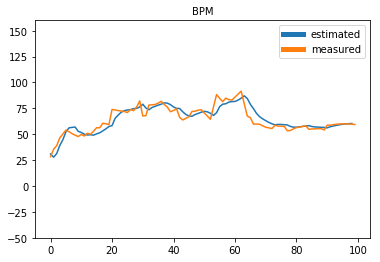

99
99


In [545]:
fig = plt.figure()

subplot1 = fig.add_subplot(111)
#subplot2 = fig.add_subplot(212)


subplot1.plot(est_x, label = 'estimated')
#subplot1.legend(handles=[red_patch])
#plt.legend(handles=[red_patch])


subplot1.set_title('BPM', fontsize = 10)

subplot1.plot(x_input[:], label = 'measured')
legend = subplot1.legend(loc='upper right')
subplot1.set_ylim([-50, 160])


# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
#frame = legend.get_frame()
#frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize(10)

for label in legend.get_lines():
    label.set_linewidth(5)  # the legend line width
plt.show()
#plt.legend(handles=[blue_patch])


#subplot2.set_title('measured x', fontsize = 60)





print len(est_x)
print len(x_input[1:])

# Kalman with updated a, b

In [659]:
x_input = smooth_window_bpm[:]
u = smooth_act_level[:]
a = 1.0#np.random.normal(0, 1)
b = 0.1#np.random.normal(0, 1)
p = 1.0
p2 = 1.0

H = 1
C = 1
Q = 1
R = 1

x = x_input[0]
est_x = np.array([])
for i in range(len(u) - 1) :
    x_ = a * x + b * u[i] # predicted bpm
    p_ = a * p * a + C * Q * C # corresponding covariance
    k = p * H * 1./(H * p * H + R)
    x = x_ + k * (x_input[i] - H * x_) # updated state, x[]
    p = (1 - k * H * p_) # updated p
    
    e = x_input[i] - (a * x + b * u[i + 1]) 
    k2 = (p2 * x)/(1 + x * p2 * x)
    p2 = 1./1 * (p2 - k2 * x * p2)
    a = a + k2 * np.conjugate(e)
    b = b + k2 * np.conjugate(e)
    
    est_x = np.append(est_x, x_)
    
    
print len(x_input)
#print est_x
print ("a:", a, "b: ", b)
print ("RESM:", np.sqrt(((est_x - x_input[1:])**2).mean()))

644
('a:', 0.94727097261302973, 'b: ', 0.047270972613028872)
('RESM:', 8.7259674057842354)


In [660]:
#print est_x
print ("a:", a, "b: ", b)
print ("RESM:", np.sqrt(((est_x - x_input[1:])**2).mean()))

('a:', 0.94727097261302973, 'b: ', 0.047270972613028872)
('RESM:', 8.7259674057842354)


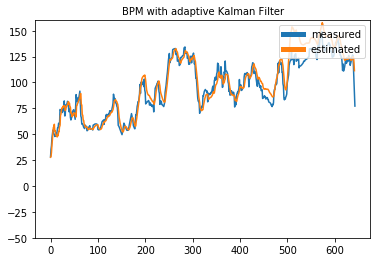

In [673]:
fig = plt.figure()

subplot1 = fig.add_subplot(111)
#subplot2 = fig.add_subplot(212)



#subplot1.legend(handles=[red_patch])
#plt.legend(handles=[red_patch])


subplot1.set_title('BPM with adaptive Kalman Filter', fontsize = 10)

subplot1.plot(x_input[:], label = 'measured')
subplot1.plot(est_x, label = 'estimated')
legend = subplot1.legend(loc='upper right')
subplot1.set_ylim([-50, 160])


# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
#frame = legend.get_frame()
#frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize(10)

for label in legend.get_lines():
    label.set_linewidth(5)  # the legend line width
plt.show()

# Kalman filter with fixed a,b

In [622]:
a = np.linspace(-2, 2, num = 100)#np.random.normal(0, 1)

In [643]:
# find fixed a, b

x_input = smooth_window_bpm[:300]
u = smooth_act_level[:300]
A = np.linspace(-1, 1, num = 100)#np.random.normal(0, 1)
B = np.linspace(-1, 1, num = 100)#np.random.normal(0, 1)
p = 1.0
p2 = 1.0

H = 1
C = 1
Q = 1
R = 1

RESM = 6
result = np.array([])
for a in A:
    for b in B:
        x = x_input[0]
        est_x = np.array([])
        for i in range(len(u) - 1) :
            x_ = a * x + b * u[i] # predicted bpm
            p_ = a * p * a + C * Q * C # corresponding covariance
            k = p * H * 1./(H * p * H + R)
            x = x_ + k * (x_input[i] - H * x_) # updated state, x[]
            p = (1 - k * H * p_) # updated p
    
    #e = x_input[i] - (a * x + b * u[i + 1]) 
    #k2 = (p2 * x)/(1 + x * p2 * x)
    #p2 = 1./1 * (p2 - k2 * x * p2)
    #a = a + k2 * np.conjugate(e)
    #b = b + k2 * np.conjugate(e)
    
            est_x = np.append(est_x, x_)
        
        RESM = np.sqrt(((est_x - x_input[1:])**2).mean())
        print (RESM, a, b)
        result = np.append(result, [(RESM, a, b)])
        #a = a - 0.05
        #b = b - 0.05
    
#print type(result)

(128.5014162282294, -1.0, -1.0)
(128.82665396462264, -1.0, -0.97979797979797978)
(128.03661988618396, -1.0, -0.95959595959595956)
(128.35972922247939, -1.0, -0.93939393939393945)
(127.57219283077137, -1.0, -0.91919191919191923)
(127.89317378238762, -1.0, -0.89898989898989901)
(127.1081391098845, -1.0, -0.87878787878787878)
(127.42699170078508, -1.0, -0.85858585858585856)
(126.64446282746769, -1.0, -0.83838383838383834)
(126.96118709041781, -1.0, -0.81818181818181812)
(126.18116814442565, -1.0, -0.79797979797979801)
(126.49576412125573, -1.0, -0.77777777777777779)
(125.71825927954801, -1.0, -0.75757575757575757)
(126.03072702142457, -1.0, -0.73737373737373735)
(125.25574051045072, -1.0, -0.71717171717171713)
(125.5660800781544, -1.0, -0.69696969696969702)
(124.79361617453414, -1.0, -0.67676767676767668)
(125.10182763874512, -1.0, -0.65656565656565657)
(124.33189066995804, -1.0, -0.63636363636363635)
(124.63797411154951, -1.0, -0.61616161616161613)
(123.87056845663425, -1.0, -0.595959595

(99.06600610980928, -0.97979797979797978, 0.11111111111111116)
(98.8701211077382, -0.97979797979797978, 0.13131313131313149)
(98.674344166452471, -0.97979797979797978, 0.1515151515151516)
(98.47867593043101, -0.97979797979797978, 0.17171717171717171)
(98.283117048925732, -0.97979797979797978, 0.19191919191919204)
(98.087668176001927, -0.97979797979797978, 0.21212121212121215)
(97.892329970579055, -0.97979797979797978, 0.23232323232323249)
(97.697103096471835, -0.97979797979797978, 0.2525252525252526)
(97.501988222431677, -0.97979797979797978, 0.27272727272727293)
(97.30698602218861, -0.97979797979797978, 0.29292929292929304)
(97.112097174493442, -0.97979797979797978, 0.31313131313131315)
(96.91732236316038, -0.97979797979797978, 0.33333333333333348)
(96.722662277110018, -0.97979797979797978, 0.35353535353535359)
(96.528117610412679, -0.97979797979797978, 0.37373737373737392)
(96.333689062332127, -0.97979797979797978, 0.39393939393939403)
(96.139377337369709, -0.97979797979797978, 0.414

(93.054454536394928, -0.95959595959595956, 0.71717171717171735)
(92.860418718826551, -0.95959595959595956, 0.73737373737373746)
(92.666515370612885, -0.95959595959595956, 0.75757575757575779)
(92.472745325067109, -0.95959595959595956, 0.7777777777777779)
(92.279109421926293, -0.95959595959595956, 0.79797979797979823)
(92.085608507406917, -0.95959595959595956, 0.81818181818181834)
(91.892243434260664, -0.95959595959595956, 0.83838383838383845)
(91.699015061830792, -0.95959595959595956, 0.85858585858585879)
(91.50592425610904, -0.95959595959595956, 0.8787878787878789)
(91.312971889792834, -0.95959595959595956, 0.89898989898989923)
(91.120158842343272, -0.95959595959595956, 0.91919191919191934)
(90.927486000043388, -0.95959595959595956, 0.93939393939393945)
(90.734954256056909, -0.95959595959595956, 0.95959595959595978)
(90.542564510487779, -0.95959595959595956, 0.97979797979797989)
(90.350317670439765, -0.95959595959595956, 1.0)
(109.9187320242884, -0.93939393939393945, -1.0)
(109.714023

(103.1042735874867, -0.91919191919191923, -0.33333333333333326)
(102.9006599244929, -0.91919191919191923, -0.31313131313131304)
(102.69714667546852, -0.91919191919191923, -0.29292929292929282)
(102.49373443856446, -0.91919191919191923, -0.27272727272727271)
(102.29042381639148, -0.91919191919191923, -0.25252525252525249)
(102.08721541605847, -0.91919191919191923, -0.23232323232323226)
(101.88410984921147, -0.91919191919191923, -0.21212121212121204)
(101.68110773207275, -0.91919191919191923, -0.19191919191919182)
(101.47820968548028, -0.91919191919191923, -0.1717171717171716)
(101.27541633492775, -0.91919191919191923, -0.15151515151515149)
(101.07272831060477, -0.91919191919191923, -0.13131313131313127)
(100.87014624743749, -0.91919191919191923, -0.11111111111111105)
(100.66767078512972, -0.91919191919191923, -0.090909090909090828)
(100.46530256820419, -0.91919191919191923, -0.070707070707070607)
(100.26304224604448, -0.91919191919191923, -0.050505050505050386)
(100.06089047293707, -0.9

(92.059624808023443, -0.89898989898989901, 0.75757575757575779)
(91.860659377232778, -0.89898989898989901, 0.7777777777777779)
(91.661837281959677, -0.89898989898989901, 0.79797979797979823)
(91.463159456949981, -0.89898989898989901, 0.81818181818181834)
(91.2646268444078, -0.89898989898989901, 0.83838383838383845)
(91.066240394061936, -0.89898989898989901, 0.85858585858585879)
(90.868001063232853, -0.89898989898989901, 0.8787878787878789)
(90.669909816900287, -0.89898989898989901, 0.89898989898989923)
(90.471967627771363, -0.89898989898989901, 0.91919191919191934)
(90.274175476349399, -0.89898989898989901, 0.93939393939393945)
(90.076534351003261, -0.89898989898989901, 0.95959595959595978)
(89.879045248037414, -0.89898989898989901, 0.97979797979797989)
(89.681709171762392, -0.89898989898989901, 1.0)
(109.77550745479003, -0.87878787878787878, -1.0)
(109.56497873192443, -0.87878787878787878, -0.97979797979797978)
(109.35453656882775, -0.87878787878787878, -0.95959595959595956)
(109.1441

(100.03957329959528, -0.85858585858585856, -0.070707070707070607)
(99.831652428012617, -0.85858585858585856, -0.050505050505050386)
(99.623846705591532, -0.85858585858585856, -0.030303030303030276)
(99.416156854407461, -0.85858585858585856, -0.010101010101010055)
(99.208583602178066, -0.85858585858585856, 0.010101010101010166)
(99.001127682313907, -0.85858585858585856, 0.030303030303030498)
(98.793789833969583, -0.85858585858585856, 0.050505050505050608)
(98.586570802095238, -0.85858585858585856, 0.070707070707070718)
(98.379471337488852, -0.85858585858585856, 0.09090909090909105)
(98.172492196848623, -0.85858585858585856, 0.11111111111111116)
(97.965634142826218, -0.85858585858585856, 0.13131313131313149)
(97.758897944080317, -0.85858585858585856, 0.1515151515151516)
(97.552284375330785, -0.85858585858585856, 0.17171717171717171)
(97.345794217413228, -0.85858585858585856, 0.19191919191919204)
(97.139428257334202, -0.85858585858585856, 0.21212121212121215)
(96.933187288326891, -0.85858

(91.79381281642442, -0.83838383838383834, 0.71717171717171735)
(91.589143834096177, -0.83838383838383834, 0.73737373737373746)
(91.384626263471873, -0.83838383838383834, 0.75757575757575779)
(91.180261123402033, -0.83838383838383834, 0.7777777777777779)
(90.976049441129305, -0.83838383838383834, 0.79797979797979823)
(90.771992252365521, -0.83838383838383834, 0.81818181818181834)
(90.568090601369548, -0.83838383838383834, 0.83838383838383845)
(90.364345541025955, -0.83838383838383834, 0.85858585858585879)
(90.160758132924244, -0.83838383838383834, 0.8787878787878789)
(89.957329447438966, -0.83838383838383834, 0.89898989898989923)
(89.754060563810427, -0.83838383838383834, 0.91919191919191934)
(89.550952570226215, -0.83838383838383834, 0.93939393939393945)
(89.348006563903496, -0.83838383838383834, 0.95959595959595978)
(89.145223651171861, -0.83838383838383834, 0.97979797979797989)
(88.942604947557257, -0.83838383838383834, 1.0)
(109.58285861314111, -0.81818181818181812, -1.0)
(109.36625

(103.63609392366945, -0.79797979797979801, -0.45454545454545447)
(103.42008909274655, -0.79797979797979801, -0.43434343434343425)
(103.20419266604827, -0.79797979797979801, -0.41414141414141414)
(102.98840532532371, -0.79797979797979801, -0.39393939393939392)
(102.77272775770186, -0.79797979797979801, -0.3737373737373737)
(102.55716065574073, -0.79797979797979801, -0.35353535353535348)
(102.34170471747723, -0.79797979797979801, -0.33333333333333326)
(102.12636064647741, -0.79797979797979801, -0.31313131313131304)
(101.9111291518871, -0.79797979797979801, -0.29292929292929282)
(101.69601094848332, -0.79797979797979801, -0.27272727272727271)
(101.48100675672588, -0.79797979797979801, -0.25252525252525249)
(101.26611730280973, -0.79797979797979801, -0.23232323232323226)
(101.05134331871784, -0.79797979797979801, -0.21212121212121204)
(100.83668554227432, -0.79797979797979801, -0.19191919191919182)
(100.62214471719847, -0.79797979797979801, -0.1717171717171716)
(100.40772159315898, -0.7979

(95.508140473146355, -0.77777777777777779, 0.29292929292929304)
(95.294672230276305, -0.77777777777777779, 0.31313131313131315)
(95.081344655451332, -0.77777777777777779, 0.33333333333333348)
(94.868158697621212, -0.77777777777777779, 0.35353535353535359)
(94.655115313652018, -0.77777777777777779, 0.37373737373737392)
(94.442215468400931, -0.77777777777777779, 0.39393939393939403)
(94.229460134792063, -0.77777777777777779, 0.41414141414141437)
(94.01685029389283, -0.77777777777777779, 0.43434343434343448)
(93.804386934991172, -0.77777777777777779, 0.45454545454545459)
(93.592071055673415, -0.77777777777777779, 0.47474747474747492)
(93.379903661903043, -0.77777777777777779, 0.49494949494949503)
(93.167885768100135, -0.77777777777777779, 0.51515151515151536)
(92.956018397221669, -0.77777777777777779, 0.53535353535353547)
(92.744302580842458, -0.77777777777777779, 0.55555555555555558)
(92.532739359237084, -0.77777777777777779, 0.57575757575757591)
(92.321329781462396, -0.77777777777777779

(103.8656484265525, -0.73737373737373735, -0.51515151515151514)
(103.6430114293786, -0.73737373737373735, -0.49494949494949492)
(103.42048709027614, -0.73737373737373735, -0.4747474747474747)
(103.19807613801346, -0.73737373737373735, -0.45454545454545447)
(102.97577930728198, -0.73737373737373735, -0.43434343434343425)
(102.75359733875229, -0.73737373737373735, -0.41414141414141414)
(102.53153097913058, -0.73737373737373735, -0.39393939393939392)
(102.30958098121582, -0.73737373737373735, -0.3737373737373737)
(102.08774810395751, -0.73737373737373735, -0.35353535353535348)
(101.8660331125139, -0.73737373737373735, -0.33333333333333326)
(101.64443677831095, -0.73737373737373735, -0.31313131313131304)
(101.42295987910182, -0.73737373737373735, -0.29292929292929282)
(101.20160319902706, -0.73737373737373735, -0.27272727272727271)
(100.9803675286752, -0.73737373737373735, -0.25252525252525249)
(100.75925366514429, -0.73737373737373735, -0.23232323232323226)
(100.5382624121038, -0.73737373

(96.357736502788583, -0.71717171717171713, 0.1515151515151516)
(96.137157077672981, -0.71717171717171713, 0.17171717171717171)
(95.916720919501998, -0.71717171717171713, 0.19191919191919204)
(95.696429018319321, -0.71717171717171713, 0.21212121212121215)
(95.476282372655021, -0.71717171717171713, 0.23232323232323249)
(95.256281989608553, -0.71717171717171713, 0.2525252525252526)
(95.036428884932448, -0.71717171717171713, 0.27272727272727293)
(94.816724083117066, -0.71717171717171713, 0.29292929292929304)
(94.597168617476157, -0.71717171717171713, 0.31313131313131315)
(94.377763530233196, -0.71717171717171713, 0.33333333333333348)
(94.158509872608676, -0.71717171717171713, 0.35353535353535359)
(93.939408704908345, -0.71717171717171713, 0.37373737373737392)
(93.72046109661224, -0.71717171717171713, 0.39393939393939403)
(93.501668126464665, -0.71717171717171713, 0.41414141414141437)
(93.283030882565143, -0.71717171717171713, 0.43434343434343448)
(93.064550462460204, -0.71717171717171713, 

(89.076449234682045, -0.69696969696969702, 0.79797979797979823)
(88.859002976836976, -0.69696969696969702, 0.81818181818181834)
(88.64174084486865, -0.69696969696969702, 0.83838383838383845)
(88.424664195986011, -0.69696969696969702, 0.85858585858585879)
(88.207774399593745, -0.69696969696969702, 0.8787878787878789)
(87.991072837413839, -0.69696969696969702, 0.89898989898989923)
(87.774560903608105, -0.69696969696969702, 0.91919191919191934)
(87.55824000490216, -0.69696969696969702, 0.93939393939393945)
(87.342111560710464, -0.69696969696969702, 0.95959595959595978)
(87.126177003262555, -0.69696969696969702, 0.97979797979797989)
(86.910437777730607, -0.69696969696969702, 1.0)
(108.9145230837272, -0.67676767676767668, -1.0)
(108.68266258327125, -0.67676767676767668, -0.97979797979797978)
(108.4508897967705, -0.67676767676767668, -0.95959595959595956)
(108.21921978309867, -0.67676767676767668, -0.93939393939393945)
(107.98765320370315, -0.67676767676767668, -0.91919191919191923)
(107.756

(104.36033659785261, -0.65656565656565657, -0.61616161616161613)
(104.1282435186265, -0.65656565656565657, -0.59595959595959591)
(103.89626825134447, -0.65656565656565657, -0.57575757575757569)
(103.66441158690824, -0.65656565656565657, -0.55555555555555558)
(103.43267432290514, -0.65656565656565657, -0.53535353535353525)
(103.20105726367369, -0.65656565656565657, -0.51515151515151514)
(102.96956122037038, -0.65656565656565657, -0.49494949494949492)
(102.73818701103693, -0.65656565656565657, -0.4747474747474747)
(102.50693546066846, -0.65656565656565657, -0.45454545454545447)
(102.27580740128208, -0.65656565656565657, -0.43434343434343425)
(102.04480367198664, -0.65656565656565657, -0.41414141414141414)
(101.81392511905285, -0.65656565656565657, -0.39393939393939392)
(101.58317259598438, -0.65656565656565657, -0.3737373737373737)
(101.35254696358969, -0.65656565656565657, -0.35353535353535348)
(101.12204909005459, -0.65656565656565657, -0.33333333333333326)
(100.89167985101554, -0.6565

(93.769040789317714, -0.63636363636363635, 0.29292929292929304)
(93.540961537446563, -0.63636363636363635, 0.31313131313131315)
(93.313047163760345, -0.63636363636363635, 0.33333333333333348)
(93.085298879345331, -0.63636363636363635, 0.35353535353535359)
(92.857717906282375, -0.63636363636363635, 0.37373737373737392)
(92.630305477760146, -0.63636363636363635, 0.39393939393939403)
(92.40306283818947, -0.63636363636363635, 0.41414141414141437)
(92.175991243318876, -0.63636363636363635, 0.43434343434343448)
(91.949091960351581, -0.63636363636363635, 0.45454545454545459)
(91.722366268063311, -0.63636363636363635, 0.47474747474747492)
(91.495815456921918, -0.63636363636363635, 0.49494949494949503)
(91.269440829207696, -0.63636363636363635, 0.51515151515151536)
(91.043243699135402, -0.63636363636363635, 0.53535353535353547)
(90.817225392977349, -0.63636363636363635, 0.55555555555555558)
(90.591387249187903, -0.63636363636363635, 0.57575757575757591)
(90.36573061852917, -0.63636363636363635,

(107.65346350208479, -0.59595959595959591, -0.93939393939393945)
(107.41244400077352, -0.59595959595959591, -0.91919191919191923)
(107.17153654972761, -0.59595959595959591, -0.89898989898989901)
(106.93074190627118, -0.59595959595959591, -0.87878787878787878)
(106.69006083420915, -0.59595959595959591, -0.85858585858585856)
(106.44949410389231, -0.59595959595959591, -0.83838383838383834)
(106.20904249228332, -0.59595959595959591, -0.81818181818181812)
(105.96870678302331, -0.59595959595959591, -0.79797979797979801)
(105.72848776649926, -0.59595959595959591, -0.77777777777777779)
(105.48838623991216, -0.59595959595959591, -0.75757575757575757)
(105.2484030073458, -0.59595959595959591, -0.73737373737373735)
(105.00853887983659, -0.59595959595959591, -0.71717171717171713)
(104.76879467544387, -0.59595959595959591, -0.69696969696969702)
(104.52917121932117, -0.59595959595959591, -0.67676767676767668)
(104.28966934378833, -0.59595959595959591, -0.65656565656565657)
(104.05028988840408, -0.59

(99.761916330406265, -0.57575757575757569, -0.29292929292929282)
(99.522517173168396, -0.57575757575757569, -0.27272727272727271)
(99.283260887009561, -0.57575757575757569, -0.25252525252525249)
(99.044148507310581, -0.57575757575757569, -0.23232323232323226)
(98.805181078849159, -0.57575757575757569, -0.21212121212121204)
(98.566359655898523, -0.57575757575757569, -0.19191919191919182)
(98.327685302327197, -0.57575757575757569, -0.1717171717171716)
(98.089159091699997, -0.57575757575757569, -0.15151515151515149)
(97.850782107379999, -0.57575757575757569, -0.13131313131313127)
(97.612555442631816, -0.57575757575757569, -0.11111111111111105)
(97.374480200725969, -0.57575757575757569, -0.090909090909090828)
(97.136557495044372, -0.57575757575757569, -0.070707070707070607)
(96.898788449187208, -0.57575757575757569, -0.050505050505050386)
(96.661174197080811, -0.57575757575757569, -0.030303030303030276)
(96.423715883086814, -0.57575757575757569, -0.010101010101010055)
(96.186414662112682, 

(91.381214307943182, -0.55555555555555558, 0.39393939393939403)
(91.145031410982298, -0.55555555555555558, 0.41414141414141437)
(90.909037135158329, -0.55555555555555558, 0.43434343434343448)
(90.673232953238042, -0.55555555555555558, 0.45454545454545459)
(90.437620352155918, -0.55555555555555558, 0.47474747474747492)
(90.202200833167765, -0.55555555555555558, 0.49494949494949503)
(89.96697591200622, -0.55555555555555558, 0.51515151515151536)
(89.73194711903794, -0.55555555555555558, 0.53535353535353547)
(89.497115999422377, -0.55555555555555558, 0.55555555555555558)
(89.262484113272606, -0.55555555555555558, 0.57575757575757591)
(89.028053035817635, -0.55555555555555558, 0.59595959595959602)
(88.793824357566677, -0.55555555555555558, 0.61616161616161635)
(88.559799684475223, -0.55555555555555558, 0.63636363636363646)
(88.325980638112895, -0.55555555555555558, 0.6565656565656568)
(88.092368855833016, -0.55555555555555558, 0.67676767676767691)
(87.858965990944355, -0.55555555555555558, 

(107.46195656563059, -0.51515151515151514, -0.97979797979797978)
(107.21063392227137, -0.51515151515151514, -0.95959595959595956)
(106.95943042444739, -0.51515151515151514, -0.93939393939393945)
(106.7083469136048, -0.51515151515151514, -0.91919191919191923)
(106.45738423872423, -0.51515151515151514, -0.89898989898989901)
(106.20654325640027, -0.51515151515151514, -0.87878787878787878)
(105.95582483092176, -0.51515151515151514, -0.85858585858585856)
(105.70522983435325, -0.51515151515151514, -0.83838383838383834)
(105.45475914661709, -0.51515151515151514, -0.81818181818181812)
(105.20441365557676, -0.51515151515151514, -0.79797979797979801)
(104.95419425712105, -0.51515151515151514, -0.77777777777777779)
(104.70410185524923, -0.51515151515151514, -0.75757575757575757)
(104.45413736215728, -0.51515151515151514, -0.73737373737373735)
(104.20430169832504, -0.51515151515151514, -0.71717171717171713)
(103.95459579260447, -0.51515151515151514, -0.69696969696969702)
(103.70502058230895, -0.51

(98.213590533336614, -0.49494949494949492, -0.25252525252525249)
(97.964624217879816, -0.49494949494949492, -0.23232323232323226)
(97.715816210313463, -0.49494949494949492, -0.21212121212121204)
(97.46716772299267, -0.49494949494949492, -0.19191919191919182)
(97.218679979894148, -0.49494949494949492, -0.1717171717171716)
(96.97035421674515, -0.49494949494949492, -0.15151515151515149)
(96.722191681153703, -0.49494949494949492, -0.13131313131313127)
(96.474193632740565, -0.49494949494949492, -0.11111111111111105)
(96.2263613432726, -0.49494949494949492, -0.090909090909090828)
(95.978696096797847, -0.49494949494949492, -0.070707070707070607)
(95.731199189782188, -0.49494949494949492, -0.050505050505050386)
(95.483871931247606, -0.49494949494949492, -0.030303030303030276)
(95.236715642912102, -0.49494949494949492, -0.010101010101010055)
(94.989731659331298, -0.49494949494949492, 0.010101010101010166)
(94.742921328041703, -0.49494949494949492, 0.030303030303030498)
(94.496286009705685, -0.4

(86.782396079473116, -0.4747474747474747, 0.6565656565656568)
(86.53959340067405, -0.4747474747474747, 0.67676767676767691)
(86.297023492399035, -0.4747474747474747, 0.69696969696969702)
(86.054688323040281, -0.4747474747474747, 0.71717171717171735)
(85.812589881309307, -0.4747474747474747, 0.73737373737373746)
(85.570730176469908, -0.4747474747474747, 0.75757575757575779)
(85.329111238573773, -0.4747474747474747, 0.7777777777777779)
(85.087735118698646, -0.4747474747474747, 0.79797979797979823)
(84.846603889189339, -0.4747474747474747, 0.81818181818181834)
(84.605719643901296, -0.4747474747474747, 0.83838383838383845)
(84.365084498446976, -0.4747474747474747, 0.85858585858585879)
(84.12470059044503, -0.4747474747474747, 0.8787878787878789)
(83.884570079772075, -0.4747474747474747, 0.89898989898989923)
(83.64469514881749, -0.4747474747474747, 0.91919191919191934)
(83.405078002740822, -0.4747474747474747, 0.93939393939393945)
(83.165720869732127, -0.4747474747474747, 0.95959595959595978

(102.21394402306514, -0.43434343434343425, -0.63636363636363635)
(101.95418254231456, -0.43434343434343425, -0.61616161616161613)
(101.69456724683833, -0.43434343434343425, -0.59595959595959591)
(101.43509925908626, -0.43434343434343425, -0.57575757575757569)
(101.17577971238207, -0.43434343434343425, -0.55555555555555558)
(100.91660975104676, -0.43434343434343425, -0.53535353535353525)
(100.65759053052334, -0.43434343434343425, -0.51515151515151514)
(100.39872321750289, -0.43434343434343425, -0.49494949494949492)
(100.14000899005272, -0.43434343434343425, -0.4747474747474747)
(99.881449037745483, -0.43434343434343425, -0.45454545454545447)
(99.623044561790451, -0.43434343434343425, -0.43434343434343425)
(99.364796775166042, -0.43434343434343425, -0.41414141414141414)
(99.10670690275424, -0.43434343434343425, -0.39393939393939392)
(98.848776181476566, -0.43434343434343425, -0.3737373737373737)
(98.591005860431736, -0.43434343434343425, -0.35353535353535348)
(98.333397201035169, -0.4343

(91.058939290352129, -0.41414141414141414, 0.21212121212121215)
(90.803837803974332, -0.41414141414141414, 0.23232323232323249)
(90.548945964822764, -0.41414141414141414, 0.2525252525252526)
(90.294265548337989, -0.41414141414141414, 0.27272727272727293)
(90.039798348567118, -0.41414141414141414, 0.29292929292929304)
(89.78554617838526, -0.41414141414141414, 0.31313131313131315)
(89.531510869719753, -0.41414141414141414, 0.33333333333333348)
(89.277694273777087, -0.41414141414141414, 0.35353535353535359)
(89.024098261272741, -0.41414141414141414, 0.37373737373737392)
(88.770724722663758, -0.41414141414141414, 0.39393939393939403)
(88.517575568384274, -0.41414141414141414, 0.41414141414141437)
(88.264652729083821, -0.41414141414141414, 0.43434343434343448)
(88.011958155868683, -0.41414141414141414, 0.45454545454545459)
(87.759493820546069, -0.41414141414141414, 0.47474747474747492)
(87.507261715871422, -0.41414141414141414, 0.49494949494949503)
(87.255263855798646, -0.41414141414141414,

(104.86634562814915, -0.3737373737373737, -0.89898989898989901)
(104.5962437922142, -0.3737373737373737, -0.87878787878787878)
(104.32628270039645, -0.3737373737373737, -0.85858585858585856)
(104.05646344812335, -0.3737373737373737, -0.83838383838383834)
(103.78678714163516, -0.3737373737373737, -0.81818181818181812)
(103.51725489811061, -0.3737373737373737, -0.79797979797979801)
(103.2478678457942, -0.3737373737373737, -0.77777777777777779)
(102.97862712412524, -0.3737373737373737, -0.75757575757575757)
(102.70953388386849, -0.3737373737373737, -0.73737373737373735)
(102.44058928724637, -0.3737373737373737, -0.71717171717171713)
(102.17179450807312, -0.3737373737373737, -0.69696969696969702)
(101.90315073189056, -0.3737373737373737, -0.67676767676767668)
(101.63465915610558, -0.3737373737373737, -0.65656565656565657)
(101.36632099012951, -0.3737373737373737, -0.63636363636363635)
(101.09813745551915, -0.3737373737373737, -0.61616161616161613)
(100.83010978611985, -0.3737373737373737, 

(89.305082889400992, -0.35353535353535348, 0.2525252525252526)
(89.042421325370555, -0.35353535353535348, 0.27272727272727293)
(88.779990798058847, -0.35353535353535348, 0.29292929292929304)
(88.517793362343923, -0.35353535353535348, 0.31313131313131315)
(88.255831095686887, -0.35353535353535348, 0.33333333333333348)
(87.994106098413198, -0.35353535353535348, 0.35353535353535359)
(87.732620493997416, -0.35353535353535348, 0.37373737373737392)
(87.471376429351722, -0.35353535353535348, 0.39393939393939403)
(87.210376075117978, -0.35353535353535348, 0.41414141414141437)
(86.949621625963744, -0.35353535353535348, 0.43434343434343448)
(86.689115300881951, -0.35353535353535348, 0.45454545454545459)
(86.428859343494423, -0.35353535353535348, 0.47474747474747492)
(86.168856022359194, -0.35353535353535348, 0.49494949494949503)
(85.909107631281955, -0.35353535353535348, 0.51515151515151536)
(85.649616489631171, -0.35353535353535348, 0.53535353535353547)
(85.390384942657334, -0.35353535353535348

(80.244995829343992, -0.33333333333333326, 0.91919191919191934)
(79.988697311887094, -0.33333333333333326, 0.93939393939393945)
(79.732721505528303, -0.33333333333333326, 0.95959595959595978)
(79.477071528383362, -0.33333333333333326, 0.97979797979797989)
(79.221750534822078, -0.33333333333333326, 1.0)
(105.43999627618989, -0.31313131313131304, -1.0)
(105.16016099865942, -0.31313131313131304, -0.97979797979797978)
(104.88046275808605, -0.31313131313131304, -0.95959595959595956)
(104.60090945346811, -0.31313131313131304, -0.93939393939393945)
(104.32150224997261, -0.31313131313131304, -0.91919191919191923)
(104.0422423246707, -0.31313131313131304, -0.89898989898989901)
(103.76313086668118, -0.31313131313131304, -0.87878787878787878)
(103.48416907731617, -0.31313131313131304, -0.85858585858585856)
(103.20535817022859, -0.31313131313131304, -0.83838383838383834)
(102.92669937156163, -0.31313131313131304, -0.81818181818181812)
(102.64819392010038, -0.31313131313131304, -0.79797979797979801

(97.019147750767303, -0.29292929292929282, -0.41414141414141414)
(96.740962087814822, -0.29292929292929282, -0.39393939393939392)
(96.462963373999614, -0.29292929292929282, -0.3737373737373737)
(96.185153230308416, -0.29292929292929282, -0.35353535353535348)
(95.907533295403752, -0.29292929292929282, -0.33333333333333326)
(95.63010522584824, -0.29292929292929282, -0.31313131313131304)
(95.352870696331905, -0.29292929292929282, -0.29292929292929282)
(95.075831399902739, -0.29292929292929282, -0.27272727272727271)
(94.79898904820044, -0.29292929292929282, -0.25252525252525249)
(94.522345371693305, -0.29292929292929282, -0.23232323232323226)
(94.245902119918568, -0.29292929292929282, -0.21212121212121204)
(93.969661061725816, -0.29292929292929282, -0.19191919191919182)
(93.693623985523914, -0.29292929292929282, -0.1717171717171716)
(93.417792699531333, -0.29292929292929282, -0.15151515151515149)
(93.142169032029884, -0.29292929292929282, -0.13131313131313127)
(92.866754831622089, -0.29292

(85.828743718600691, -0.27272727272727271, 0.37373737373737392)
(85.55638120380425, -0.27272727272727271, 0.39393939393939403)
(85.284292231497489, -0.27272727272727271, 0.41414141414141437)
(85.012479428161711, -0.27272727272727271, 0.43434343434343448)
(84.740945451293712, -0.27272727272727271, 0.45454545454545459)
(84.46969298981746, -0.27272727272727271, 0.47474747474747492)
(84.198724764501378, -0.27272727272727271, 0.49494949494949503)
(83.928043528381266, -0.27272727272727271, 0.51515151515151536)
(83.657652067188849, -0.27272727272727271, 0.53535353535353547)
(83.387553199786083, -0.27272727272727271, 0.55555555555555558)
(83.117749778605329, -0.27272727272727271, 0.57575757575757591)
(82.848244690095257, -0.27272727272727271, 0.59595959595959602)
(82.579040855172877, -0.27272727272727271, 0.61616161616161635)
(82.310141229681335, -0.27272727272727271, 0.63636363636363646)
(82.041548804853903, -0.27272727272727271, 0.6565656565656568)
(81.773266607784024, -0.27272727272727271, 

(102.21998751714756, -0.23232323232323226, -0.85858585858585856)
(101.92836286018984, -0.23232323232323226, -0.83838383838383834)
(101.63690383518419, -0.23232323232323226, -0.81818181818181812)
(101.34561187114943, -0.23232323232323226, -0.79797979797979801)
(101.05448841275722, -0.23232323232323226, -0.77777777777777779)
(100.76353492053428, -0.23232323232323226, -0.75757575757575757)
(100.47275287106754, -0.23232323232323226, -0.73737373737373735)
(100.18214375721215, -0.23232323232323226, -0.71717171717171713)
(99.891709088302548, -0.23232323232323226, -0.69696969696969702)
(99.601450390366495, -0.23232323232323226, -0.67676767676767668)
(99.311369206342363, -0.23232323232323226, -0.65656565656565657)
(99.021467096299304, -0.23232323232323226, -0.63636363636363635)
(98.731745637660808, -0.23232323232323226, -0.61616161616161613)
(98.442206425431451, -0.23232323232323226, -0.59595959595959591)
(98.152851072426756, -0.23232323232323226, -0.57575757575757569)
(97.86368120950668, -0.23

(93.397921397867876, -0.21212121212121204, -0.27272727272727271)
(93.108506909111185, -0.21212121212121204, -0.25252525252525249)
(92.819312247780189, -0.21212121212121204, -0.23232323232323226)
(92.53033947502324, -0.21212121212121204, -0.21212121212121204)
(92.241590676225798, -0.21212121212121204, -0.19191919191919182)
(91.953067961340707, -0.21212121212121204, -0.1717171717171716)
(91.664773465223348, -0.21212121212121204, -0.15151515151515149)
(91.376709347971712, -0.21212121212121204, -0.13131313131313127)
(91.088877795271486, -0.21212121212121204, -0.11111111111111105)
(90.801281018746195, -0.21212121212121204, -0.090909090909090828)
(90.513921256312557, -0.21212121212121204, -0.070707070707070607)
(90.226800772540955, -0.21212121212121204, -0.050505050505050386)
(89.939921859021297, -0.21212121212121204, -0.030303030303030276)
(89.653286834734232, -0.21212121212121204, -0.010101010101010055)
(89.366898046427806, -0.21212121212121204, 0.010101010101010166)
(89.080757868999569, -

(81.720871255391003, -0.19191919191919182, 0.51515151515151536)
(81.438815575356614, -0.19191919191919182, 0.53535353535353547)
(81.157092177224285, -0.19191919191919182, 0.55555555555555558)
(80.8757045334183, -0.19191919191919182, 0.57575757575757591)
(80.594656160690022, -0.19191919191919182, 0.59595959595959602)
(80.313950620746411, -0.19191919191919182, 0.61616161616161635)
(80.033591520887711, -0.19191919191919182, 0.63636363636363646)
(79.753582514653814, -0.19191919191919182, 0.6565656565656568)
(79.473927302479851, -0.19191919191919182, 0.67676767676767691)
(79.194629632360687, -0.19191919191919182, 0.69696969696969702)
(78.915693300524723, -0.19191919191919182, 0.71717171717171735)
(78.637122152116902, -0.19191919191919182, 0.73737373737373746)
(78.358920081891114, -0.19191919191919182, 0.75757575757575779)
(78.081091034911992, -0.19191919191919182, 0.7777777777777779)
(77.803639007266227, -0.19191919191919182, 0.79797979797979823)
(77.526568046783524, -0.19191919191919182, 0

(99.873152446291286, -0.15151515151515149, -0.79797979797979801)
(99.568174566162114, -0.15151515151515149, -0.77777777777777779)
(99.263382606636824, -0.15151515151515149, -0.75757575757575757)
(98.958778285615722, -0.15151515151515149, -0.73737373737373735)
(98.654363341151694, -0.15151515151515149, -0.71717171717171713)
(98.350139531728885, -0.15151515151515149, -0.69696969696969702)
(98.046108636545839, -0.15151515151515149, -0.67676767676767668)
(97.742272455802876, -0.15151515151515149, -0.65656565656565657)
(97.438632810993923, -0.15151515151515149, -0.63636363636363635)
(97.135191545202801, -0.15151515151515149, -0.61616161616161613)
(96.831950523404302, -0.15151515151515149, -0.59595959595959591)
(96.528911632769621, -0.15151515151515149, -0.57575757575757569)
(96.226076782976634, -0.15151515151515149, -0.55555555555555558)
(95.923447906525055, -0.15151515151515149, -0.53535353535353525)
(95.621026959056337, -0.15151515151515149, -0.51515151515151514)
(95.318815919678599, -0.1

(87.600430486931316, -0.13131313131313127, -0.010101010101010055)
(87.300762966872895, -0.13131313131313127, 0.010101010101010166)
(87.001374298838471, -0.13131313131313127, 0.030303030303030498)
(86.702267371511624, -0.13131313131313127, 0.050505050505050608)
(86.403445110838121, -0.13131313131313127, 0.070707070707070718)
(86.104910480576962, -0.13131313131313127, 0.09090909090909105)
(85.806666482859924, -0.13131313131313127, 0.11111111111111116)
(85.508716158759924, -0.13131313131313127, 0.13131313131313149)
(85.211062588868202, -0.13131313131313127, 0.1515151515151516)
(84.913708893880553, -0.13131313131313127, 0.17171717171717171)
(84.616658235192617, -0.13131313131313127, 0.19191919191919204)
(84.319913815504592, -0.13131313131313127, 0.21212121212121215)
(84.023478879435132, -0.13131313131313127, 0.23232323232323249)
(83.727356714144946, -0.13131313131313127, 0.2525252525252526)
(83.431550649969893, -0.13131313131313127, 0.27272727272727293)
(83.136064061064005, -0.131313131313

(78.095920094533838, -0.11111111111111105, 0.59595959595959602)
(77.802870940332156, -0.11111111111111105, 0.61616161616161635)
(77.510219992340353, -0.11111111111111105, 0.63636363636363646)
(77.217971778083239, -0.11111111111111105, 0.6565656565656568)
(76.926130887609077, -0.11111111111111105, 0.67676767676767691)
(76.634701974439196, -0.11111111111111105, 0.69696969696969702)
(76.343689756531361, -0.11111111111111105, 0.71717171717171735)
(76.053099017257367, -0.11111111111111105, 0.73737373737373746)
(75.762934606394694, -0.11111111111111105, 0.75757575757575779)
(75.473201441132545, -0.11111111111111105, 0.7777777777777779)
(75.183904507092123, -0.11111111111111105, 0.79797979797979823)
(74.895048859361651, -0.11111111111111105, 0.81818181818181834)
(74.606639623545817, -0.11111111111111105, 0.83838383838383845)
(74.318681996830037, -0.11111111111111105, 0.85858585858585879)
(74.031181249059543, -0.11111111111111105, 0.8787878787878789)
(73.744142723833377, -0.11111111111111105, 

(97.905446734880869, -0.070707070707070607, -0.77777777777777779)
(97.585538834918736, -0.070707070707070607, -0.75757575757575757)
(97.265837022766604, -0.070707070707070607, -0.73737373737373735)
(96.946343337283679, -0.070707070707070607, -0.71717171717171713)
(96.627059842958644, -0.070707070707070607, -0.69696969696969702)
(96.307988630289955, -0.070707070707070607, -0.67676767676767668)
(95.989131816172474, -0.070707070707070607, -0.65656565656565657)
(95.6704915442904, -0.070707070707070607, -0.63636363636363635)
(95.352069985516707, -0.070707070707070607, -0.61616161616161613)
(95.033869338319263, -0.070707070707070607, -0.59595959595959591)
(94.715891829173671, -0.070707070707070607, -0.57575757575757569)
(94.398139712982939, -0.070707070707070607, -0.55555555555555558)
(94.080615273504108, -0.070707070707070607, -0.53535353535353525)
(93.763320823781982, -0.070707070707070607, -0.51515151515151514)
(93.446258706590129, -0.070707070707070607, -0.49494949494949492)
(93.12943129

(86.896653651248286, -0.050505050505050386, -0.11111111111111105)
(86.58099398768536, -0.050505050505050386, -0.090909090909090828)
(86.265632442994189, -0.050505050505050386, -0.070707070707070607)
(85.950572298661825, -0.050505050505050386, -0.050505050505050386)
(85.635816881307136, -0.050505050505050386, -0.030303030303030276)
(85.321369563396047, -0.050505050505050386, -0.010101010101010055)
(85.007233763968557, -0.050505050505050386, 0.010101010101010166)
(84.693412949378441, -0.050505050505050386, 0.030303030303030498)
(84.379910634045203, -0.050505050505050386, 0.050505050505050608)
(84.06673038121869, -0.050505050505050386, 0.070707070707070718)
(83.753875803756927, -0.050505050505050386, 0.09090909090909105)
(83.441350564916675, -0.050505050505050386, 0.11111111111111116)
(83.129158379157531, -0.050505050505050386, 0.13131313131313149)
(82.817303012959499, -0.050505050505050386, 0.1515151515151516)
(82.505788285654262, -0.050505050505050386, 0.17171717171717171)
(82.194618070

(69.894796817758547, -0.030303030303030276, 0.95959595959595978)
(69.597710597775929, -0.030303030303030276, 0.97979797979797989)
(69.301204136177034, -0.030303030303030276, 1.0)
(100.20787850058599, -0.010101010101010055, -1.0)
(99.873351490507773, -0.010101010101010055, -0.97979797979797978)
(99.53902260903665, -0.010101010101010055, -0.95959595959595956)
(99.204893873692512, -0.010101010101010055, -0.93939393939393945)
(98.870967313622259, -0.010101010101010055, -0.91919191919191923)
(98.537244984242434, -0.010101010101010055, -0.89898989898989901)
(98.203728967643329, -0.010101010101010055, -0.87878787878787878)
(97.870421372999942, -0.010101010101010055, -0.85858585858585856)
(97.537324336990451, -0.010101010101010055, -0.83838383838383834)
(97.204440024221398, -0.010101010101010055, -0.81818181818181812)
(96.871770627660794, -0.010101010101010055, -0.79797979797979801)
(96.539318369078416, -0.010101010101010055, -0.77777777777777779)
(96.207085499493843, -0.010101010101010055, -0

(89.707531724743006, 0.010101010101010166, -0.39393939393939392)
(89.375741172090898, 0.010101010101010166, -0.3737373737373737)
(89.044229803347136, 0.010101010101010166, -0.35353535353535348)
(88.713000748356535, 0.010101010101010166, -0.33333333333333326)
(88.38205718119724, 0.010101010101010166, -0.31313131313131304)
(88.051402320910427, 0.010101010101010166, -0.29292929292929282)
(87.72103943224306, 0.010101010101010166, -0.27272727272727271)
(87.390971826404083, 0.010101010101010166, -0.25252525252525249)
(87.061202861834289, 0.010101010101010166, -0.23232323232323226)
(86.731735944990035, 0.010101010101010166, -0.21212121212121204)
(86.40257453114107, 0.010101010101010166, -0.19191919191919182)
(86.073722125182897, 0.010101010101010166, -0.1717171717171716)
(85.745182282463631, 0.010101010101010166, -0.15151515151515149)
(85.416958609625794, 0.010101010101010166, -0.13131313131313127)
(85.089054765463473, 0.010101010101010166, -0.11111111111111105)
(84.761474461794577, 0.0101010

(71.495389598529187, 0.030303030303030498, 0.69696969696969702)
(71.18099432441241, 0.030303030303030498, 0.71717171717171735)
(70.867157009065679, 0.030303030303030498, 0.73737373737373746)
(70.553885098214693, 0.030303030303030498, 0.75757575757575779)
(70.241186156880715, 0.030303030303030498, 0.7777777777777779)
(69.929067871436956, 0.030303030303030498, 0.79797979797979823)
(69.617538051697025, 0.030303030303030498, 0.81818181818181834)
(69.306604633035548, 0.030303030303030498, 0.83838383838383845)
(68.996275678541551, 0.030303030303030498, 0.85858585858585879)
(68.68655938120412, 0.030303030303030498, 0.8787878787878789)
(68.377464066130983, 0.030303030303030498, 0.89898989898989923)
(68.068998192799668, 0.030303030303030498, 0.91919191919191934)
(67.761170357341626, 0.030303030303030498, 0.93939393939393945)
(67.453989294859042, 0.030303030303030498, 0.95959595959595978)
(67.147463881774584, 0.030303030303030498, 0.97979797979797989)
(66.841603138213728, 0.030303030303030498, 1

(88.634962093037274, 0.070707070707070718, -0.43434343434343425)
(88.289298325626902, 0.070707070707070718, -0.41414141414141414)
(87.943932418480003, 0.070707070707070718, -0.39393939393939392)
(87.598867894614102, 0.070707070707070718, -0.3737373737373737)
(87.254108329677948, 0.070707070707070718, -0.35353535353535348)
(86.909657352871534, 0.070707070707070718, -0.33333333333333326)
(86.565518647883948, 0.070707070707070718, -0.31313131313131304)
(86.221695953849064, 0.070707070707070718, -0.29292929292929282)
(85.878193066319724, 0.070707070707070718, -0.27272727272727271)
(85.535013838260539, 0.070707070707070718, -0.25252525252525249)
(85.192162181059828, 0.070707070707070718, -0.23232323232323226)
(84.849642065561028, 0.070707070707070718, -0.21212121212121204)
(84.507457523113814, 0.070707070707070718, -0.19191919191919182)
(84.165612646645641, 0.070707070707070718, -0.1717171717171716)
(83.824111591753521, 0.070707070707070718, -0.15151515151515149)
(83.4829585778172, 0.070707

(73.293006274241094, 0.09090909090909105, 0.43434343434343448)
(72.960037025481128, 0.09090909090909105, 0.45454545454545459)
(72.627600350343613, 0.09090909090909105, 0.47474747474747492)
(72.295703595614256, 0.09090909090909105, 0.49494949494949503)
(71.964354231568109, 0.09090909090909105, 0.51515151515151536)
(71.633559854263453, 0.09090909090909105, 0.53535353535353547)
(71.303328187877014, 0.09090909090909105, 0.55555555555555558)
(70.973667087081466, 0.09090909090909105, 0.57575757575757591)
(70.644584539465384, 0.09090909090909105, 0.59595959595959602)
(70.316088667996127, 0.09090909090909105, 0.61616161616161635)
(69.988187733526445, 0.09090909090909105, 0.63636363636363646)
(69.660890137344722, 0.09090909090909105, 0.6565656565656568)
(69.334204423769847, 0.09090909090909105, 0.67676767676767691)
(69.00813928279058, 0.09090909090909105, 0.69696969696969702)
(68.682703552750212, 0.09090909090909105, 0.71717171717171735)
(68.357906223076583, 0.09090909090909105, 0.7373737373737

(88.211170251237519, 0.13131313131313149, -0.51515151515151514)
(87.849752742506695, 0.13131313131313149, -0.49494949494949492)
(87.488645644417645, 0.13131313131313149, -0.4747474747474747)
(87.12785281652225, 0.13131313131313149, -0.45454545454545447)
(86.767378179179843, 0.13131313131313149, -0.43434343434343425)
(86.407225714683321, 0.13131313131313149, -0.41414141414141414)
(86.047399468408173, 0.13131313131313149, -0.39393939393939392)
(85.68790354998518, 0.13131313131313149, -0.3737373737373737)
(85.328742134496963, 0.13131313131313149, -0.35353535353535348)
(84.969919463699398, 0.13131313131313149, -0.33333333333333326)
(84.611439847267761, 0.13131313131313149, -0.31313131313131304)
(84.253307664068757, 0.13131313131313149, -0.29292929292929282)
(83.89552736345847, 0.13131313131313149, -0.27272727272727271)
(83.538103466607126, 0.13131313131313149, -0.25252525252525249)
(83.181040567850985, 0.13131313131313149, -0.23232323232323226)
(82.824343336072118, 0.13131313131313149, -0.

(71.121596153275675, 0.1515151515151516, 0.41414141414141437)
(70.775179274567023, 0.1515151515151516, 0.43434343434343448)
(70.4293609981153, 0.1515151515151516, 0.45454545454545459)
(70.084150185023063, 0.1515151515151516, 0.47474747474747492)
(69.739555856122109, 0.1515151515151516, 0.49494949494949503)
(69.395587195150682, 0.1515151515151516, 0.51515151515151536)
(69.05225355199228, 0.1515151515151516, 0.53535353535353547)
(68.709564445976369, 0.1515151515151516, 0.55555555555555558)
(68.367529569242222, 0.1515151515151516, 0.57575757575757591)
(68.026158790166306, 0.1515151515151516, 0.59595959595959602)
(67.685462156853987, 0.1515151515151516, 0.61616161616161635)
(67.345449900696238, 0.1515151515151516, 0.63636363636363646)
(67.006132439991958, 0.1515151515151516, 0.6565656565656568)
(66.667520383636429, 0.1515151515151516, 0.67676767676767691)
(66.329624534876544, 0.1515151515151516, 0.69696969696969702)
(65.992455895133148, 0.1515151515151516, 0.71717171717171735)
(65.65602566

(80.644598009029906, 0.19191919191919204, -0.21212121212121204)
(80.272822731264384, 0.19191919191919204, -0.19191919191919182)
(79.901464329144403, 0.19191919191919204, -0.1717171717171716)
(79.530528642324796, 0.19191919191919204, -0.15151515151515149)
(79.160021613206538, 0.19191919191919204, -0.13131313131313127)
(78.789949289034197, 0.19191919191919204, -0.11111111111111105)
(78.420317824039756, 0.19191919191919204, -0.090909090909090828)
(78.051133481633727, 0.19191919191919204, -0.070707070707070607)
(77.682402636644653, 0.19191919191919204, -0.050505050505050386)
(77.314131777607912, 0.19191919191919204, -0.030303030303030276)
(76.946327509104904, 0.19191919191919204, -0.010101010101010055)
(76.578996554153946, 0.19191919191919204, 0.010101010101010166)
(76.212145756653385, 0.19191919191919204, 0.030303030303030498)
(75.845782083878674, 0.19191919191919204, 0.050505050505050608)
(75.479912629034061, 0.19191919191919204, 0.070707070707070718)
(75.114544613860176, 0.1919191919191

(93.135022690231011, 0.23232323232323249, -0.93939393939393945)
(92.73950737370734, 0.23232323232323249, -0.91919191919191923)
(92.344266461006427, 0.23232323232323249, -0.89898989898989901)
(91.949303490674453, 0.23232323232323249, -0.87878787878787878)
(91.554622059808239, 0.23232323232323249, -0.85858585858585856)
(91.160225825213146, 0.23232323232323249, -0.83838383838383834)
(90.766118504587141, 0.23232323232323249, -0.81818181818181812)
(90.372303877731341, 0.23232323232323249, -0.79797979797979801)
(89.978785787788013, 0.23232323232323249, -0.77777777777777779)
(89.585568142506276, 0.23232323232323249, -0.75757575757575757)
(89.192654915536565, 0.23232323232323249, -0.73737373737373735)
(88.800050147754476, 0.23232323232323249, -0.71717171717171713)
(88.407757948614432, 0.23232323232323249, -0.69696969696969702)
(88.015782497534204, 0.23232323232323249, -0.67676767676767668)
(87.624128045311039, 0.23232323232323249, -0.65656565656565657)
(87.232798915569859, 0.23232323232323249,

(78.295723123516055, 0.2525252525252526, -0.21212121212121204)
(77.906966216058336, 0.2525252525252526, -0.19191919191919182)
(77.518675433141183, 0.2525252525252526, -0.1717171717171716)
(77.130857814432403, 0.2525252525252526, -0.15151515151515149)
(76.743520533231703, 0.2525252525252526, -0.13131313131313127)
(76.356670899416443, 0.2525252525252526, -0.11111111111111105)
(75.970316362457581, 0.2525252525252526, -0.090909090909090828)
(75.584464514507587, 0.2525252525252526, -0.070707070707070607)
(75.199123093562008, 0.2525252525252526, -0.050505050505050386)
(74.814299986696341, 0.2525252525252526, -0.030303030303030276)
(74.430003233380006, 0.2525252525252526, -0.010101010101010055)
(74.04624102886919, 0.2525252525252526, 0.010101010101010166)
(73.663021727680217, 0.2525252525252526, 0.030303030303030498)
(73.28035384714552, 0.2525252525252526, 0.050505050505050608)
(72.898246071053649, 0.2525252525252526, 0.070707070707070718)
(72.516707253375657, 0.2525252525252526, 0.0909090909

(60.31879646822631, 0.27272727272727293, 0.69696969696969702)
(59.955925924145816, 0.27272727272727293, 0.71717171717171735)
(59.594084910938051, 0.27272727272727293, 0.73737373737373746)
(59.233292296027329, 0.27272727272727293, 0.75757575757575779)
(58.873567353993536, 0.27272727272727293, 0.7777777777777779)
(58.514929775638436, 0.27272727272727293, 0.79797979797979823)
(58.15739967720932, 0.27272727272727293, 0.81818181818181834)
(57.800997609777632, 0.27272727272727293, 0.83838383838383845)
(57.44574456877077, 0.27272727272727293, 0.85858585858585879)
(57.091662003654058, 0.27272727272727293, 0.8787878787878789)
(56.73877182775972, 0.27272727272727293, 0.89898989898989923)
(56.387096428258907, 0.27272727272727293, 0.91919191919191934)
(56.036658676272268, 0.27272727272727293, 0.93939393939393945)
(55.687481937113979, 0.27272727272727293, 0.95959595959595978)
(55.339590080663186, 0.27272727272727293, 0.97979797979797989)
(54.993007491856254, 0.27272727272727293, 1.0)
(92.5906923083

(72.916993637740575, 0.31313131313131315, -0.070707070707070607)
(72.513306717160603, 0.31313131313131315, -0.050505050505050386)
(72.110208915367323, 0.31313131313131315, -0.030303030303030276)
(71.70771016738037, 0.31313131313131315, -0.010101010101010055)
(71.305820617606884, 0.31313131313131315, 0.010101010101010166)
(70.904550624919921, 0.31313131313131315, 0.030303030303030498)
(70.503910767868263, 0.31313131313131315, 0.050505050505050608)
(70.103911850020367, 0.31313131313131315, 0.070707070707070718)
(69.704564905445878, 0.31313131313131315, 0.09090909090909105)
(69.305881204337965, 0.31313131313131315, 0.11111111111111116)
(68.907872258779634, 0.31313131313131315, 0.13131313131313149)
(68.510549828657602, 0.31313131313131315, 0.1515151515151516)
(68.113925927726825, 0.31313131313131315, 0.17171717171717171)
(67.718012829829362, 0.31313131313131315, 0.19191919191919204)
(67.322823075270762, 0.31313131313131315, 0.21212121212121215)
(66.928369477357506, 0.31313131313131315, 0.2

(83.77665474493665, 0.35353535353535359, -0.67676767676767668)
(83.344581672186777, 0.35353535353535359, -0.65656565656565657)
(82.912900699151621, 0.35353535353535359, -0.63636363636363635)
(82.481617982184488, 0.35353535353535359, -0.61616161616161613)
(82.050739801337173, 0.35353535353535359, -0.59595959595959591)
(81.620272563319261, 0.35353535353535359, -0.57575757575757569)
(81.190222804537214, 0.35353535353535359, -0.55555555555555558)
(80.760597194215549, 0.35353535353535359, -0.53535353535353525)
(80.331402537602656, 0.35353535353535359, -0.51515151515151514)
(79.902645779263437, 0.35353535353535359, -0.49494949494949492)
(79.474334006461561, 0.35353535353535359, -0.4747474747474747)
(79.046474452633575, 0.35353535353535359, -0.45454545454545447)
(78.619074500957893, 0.35353535353535359, -0.43434343434343425)
(78.192141688021039, 0.35353535353535359, -0.41414141414141414)
(77.765683707584188, 0.35353535353535359, -0.39393939393939392)
(77.339708414452687, 0.35353535353535359, 

(63.324621778695821, 0.37373737373737392, 0.2525252525252526)
(62.913034197290891, 0.37373737373737392, 0.27272727272727293)
(62.502362350884894, 0.37373737373737392, 0.29292929292929304)
(62.092624409106207, 0.37373737373737392, 0.31313131313131315)
(61.683838982480268, 0.37373737373737392, 0.33333333333333348)
(61.276025134304966, 0.37373737373737392, 0.35353535353535359)
(60.869202392840627, 0.37373737373737392, 0.37373737373737392)
(60.4633907638202, 0.37373737373737392, 0.39393939393939403)
(60.058610743285115, 0.37373737373737392, 0.41414141414141437)
(59.654883330752284, 0.37373737373737392, 0.43434343434343448)
(59.252230042717322, 0.37373737373737392, 0.45454545454545459)
(58.850672926498632, 0.37373737373737392, 0.47474747474747492)
(58.450234574427043, 0.37373737373737392, 0.49494949494949503)
(58.050938138384765, 0.37373737373737392, 0.51515151515151536)
(57.652807344697486, 0.37373737373737392, 0.53535353535353547)
(57.25586650938255, 0.37373737373737392, 0.555555555555555

(77.315924539014915, 0.41414141414141437, -0.49494949494949492)
(76.864082563023501, 0.41414141414141437, -0.4747474747474747)
(76.412746351571784, 0.41414141414141437, -0.45454545454545447)
(75.961924919828817, 0.41414141414141437, -0.43434343434343425)
(75.511627487847718, 0.41414141414141437, -0.41414141414141414)
(75.061863486080327, 0.41414141414141437, -0.39393939393939392)
(74.612642561057598, 0.41414141414141437, -0.3737373737373737)
(74.163974581241504, 0.41414141414141437, -0.35353535353535348)
(73.715869643053367, 0.41414141414141437, -0.33333333333333326)
(73.268338077084465, 0.41414141414141437, -0.31313131313131304)
(72.821390454494647, 0.41414141414141437, -0.29292929292929282)
(72.375037593604659, 0.41414141414141437, -0.27272727272727271)
(71.929290566688621, 0.41414141414141437, -0.25252525252525249)
(71.484160706972432, 0.41414141414141437, -0.23232323232323226)
(71.03965961584494, 0.41414141414141437, -0.21212121212121204)
(70.595799170288217, 0.41414141414141437, -

(60.248062728233947, 0.43434343434343448, 0.23232323232323249)
(59.814808693841279, 0.43434343434343448, 0.2525252525252526)
(59.382630654214879, 0.43434343434343448, 0.27272727272727293)
(58.951552273942944, 0.43434343434343448, 0.29292929292929304)
(58.521597853770245, 0.43434343434343448, 0.31313131313131315)
(58.092792349549185, 0.43434343434343448, 0.33333333333333348)
(57.665161391742664, 0.43434343434343448, 0.35353535353535359)
(57.238731305489914, 0.43434343434343448, 0.37373737373737392)
(56.813529131245382, 0.43434343434343448, 0.39393939393939403)
(56.389582646000484, 0.43434343434343448, 0.41414141414141437)
(55.966920385097346, 0.43434343434343448, 0.43434343434343448)
(55.545571664642935, 0.43434343434343448, 0.45454545454545459)
(55.12556660453113, 0.43434343434343448, 0.47474747474747492)
(54.706936152079159, 0.43434343434343448, 0.49494949494949503)
(54.289712106283886, 0.43434343434343448, 0.51515151515151536)
(53.873927142702009, 0.43434343434343448, 0.5353535353535

(44.109874886596081, 0.45454545454545459, 0.95959595959595978)
(43.733902379240135, 0.45454545454545459, 0.97979797979797989)
(43.360687565068503, 0.45454545454545459, 1.0)
(86.617938301255691, 0.47474747474747492, -1.0)
(86.128171357979596, 0.47474747474747492, -0.97979797979797978)
(85.63876030158346, 0.47474747474747492, -0.95959595959595956)
(85.149716818650404, 0.47474747474747492, -0.93939393939393945)
(84.661047279031209, 0.47474747474747492, -0.91919191919191923)
(84.172758195571078, 0.47474747474747492, -0.89898989898989901)
(83.684856227990949, 0.47474747474747492, -0.87878787878787878)
(83.197348186890366, 0.47474747474747492, -0.85858585858585856)
(82.71024103787596, 0.47474747474747492, -0.83838383838383834)
(82.223541905819957, 0.47474747474747492, -0.81818181818181812)
(81.737258079253152, 0.47474747474747492, -0.79797979797979801)
(81.251397014897265, 0.47474747474747492, -0.77777777777777779)
(80.765966342341216, 0.47474747474747492, -0.75757575757575757)
(80.280973868

(66.246383916452416, 0.49494949494949503, -0.19191919191919182)
(65.768512293582376, 0.49494949494949503, -0.1717171717171716)
(65.291452063684204, 0.49494949494949503, -0.15151515151515149)
(64.815221143075931, 0.49494949494949503, -0.13131313131313127)
(64.339837946916589, 0.49494949494949503, -0.11111111111111105)
(63.865321405386531, 0.49494949494949503, -0.090909090909090828)
(63.391690980438014, 0.49494949494949503, -0.070707070707070607)
(62.918966683135821, 0.49494949494949503, -0.050505050505050386)
(62.447169091608565, 0.49494949494949503, -0.030303030303030276)
(61.976319369631291, 0.49494949494949503, -0.010101010101010055)
(61.506439285860992, 0.49494949494949503, 0.010101010101010166)
(61.037551233746747, 0.49494949494949503, 0.030303030303030498)
(60.569678252137031, 0.49494949494949503, 0.050505050505050608)
(60.102844046606734, 0.49494949494949503, 0.070707070707070718)
(59.63707301152737, 0.49494949494949503, 0.09090909090909105)
(59.172390252903831, 0.494949494949495

(40.71773128838246, 0.51515151515151536, 0.89898989898989923)
(40.327668054824024, 0.51515151515151536, 0.91919191919191934)
(39.941119669197747, 0.51515151515151536, 0.93939393939393945)
(39.558189169124297, 0.51515151515151536, 0.95959595959595978)
(39.178982637036633, 0.51515151515151536, 0.97979797979797989)
(38.803609250019001, 0.51515151515151536, 1.0)
(84.307731784964631, 0.53535353535353547, -1.0)
(83.786283806770527, 0.53535353535353547, -0.97979797979797978)
(83.265221816366932, 0.53535353535353547, -0.95959595959595956)
(82.744558084550789, 0.53535353535353547, -0.93939393939393945)
(82.224300176925354, 0.53535353535353547, -0.91919191919191923)
(81.704455845818913, 0.53535353535353547, -0.89898989898989901)
(81.185033035876344, 0.53535353535353547, -0.87878787878787878)
(80.666039889844669, 0.53535353535353547, -0.85858585858585856)
(80.147484754559869, 0.53535353535353547, -0.83838383838383834)
(79.629376187142881, 0.53535353535353547, -0.81818181818181812)
(79.11172296141

(64.627031657144045, 0.55555555555555558, -0.27272727272727271)
(64.115233198133993, 0.55555555555555558, -0.25252525252525249)
(63.604303486666879, 0.55555555555555558, -0.23232323232323226)
(63.09426362778364, 0.55555555555555558, -0.21212121212121204)
(62.585135377146969, 0.55555555555555558, -0.19191919191919182)
(62.076941164611846, 0.55555555555555558, -0.1717171717171716)
(61.569704118737363, 0.55555555555555558, -0.15151515151515149)
(61.063448092278279, 0.55555555555555558, -0.13131313131313127)
(60.558197688695934, 0.55555555555555558, -0.11111111111111105)
(60.053978289729542, 0.55555555555555558, -0.090909090909090828)
(59.550816084070185, 0.55555555555555558, -0.070707070707070607)
(59.048738097181328, 0.55555555555555558, -0.050505050505050386)
(58.547772222310812, 0.55555555555555558, -0.030303030303030276)
(58.047947252740833, 0.55555555555555558, -0.010101010101010055)
(57.549292915323377, 0.55555555555555558, 0.010101010101010166)
(57.051839905350228, 0.55555555555555

(34.246885750150049, 0.57575757575757591, 0.97979797979797989)
(33.879987052401631, 0.57575757575757591, 1.0)
(81.791534827926895, 0.59595959595959602, -1.0)
(81.233512380894467, 0.59595959595959602, -0.97979797979797978)
(80.675907793490993, 0.59595959595959602, -0.95959595959595956)
(80.118733401106468, 0.59595959595959602, -0.93939393939393945)
(79.561998241736447, 0.59595959595959602, -0.91919191919191923)
(79.005711600904874, 0.59595959595959602, -0.89898989898989901)
(78.44988301992187, 0.59595959595959602, -0.87878787878787878)
(77.894522304461702, 0.59595959595959602, -0.85858585858585856)
(77.339639533475491, 0.59595959595959602, -0.83838383838383834)
(76.785245068452767, 0.59595959595959602, -0.81818181818181812)
(76.231349563047644, 0.59595959595959602, -0.79797979797979801)
(75.677963973085085, 0.59595959595959602, -0.77777777777777779)
(75.125099566964636, 0.59595959595959602, -0.75757575757575757)
(74.572767936478797, 0.59595959595959602, -0.73737373737373735)
(74.0209810

(59.590476771306363, 0.61616161616161635, -0.23232323232323226)
(59.045070178342591, 0.61616161616161635, -0.21212121212121204)
(58.500750141135612, 0.61616161616161635, -0.19191919191919182)
(57.957547273518507, 0.61616161616161635, -0.1717171717171716)
(57.415493283825974, 0.61616161616161635, -0.15151515151515149)
(56.874621020841772, 0.61616161616161635, -0.13131313131313127)
(56.334964521867455, 0.61616161616161635, -0.11111111111111105)
(55.796559063011507, 0.61616161616161635, -0.090909090909090828)
(55.259441211801779, 0.61616161616161635, -0.070707070707070607)
(54.72364888222824, 0.61616161616161635, -0.050505050505050386)
(54.189221392326729, 0.61616161616161635, -0.030303030303030276)
(53.656199524418241, 0.61616161616161635, -0.010101010101010055)
(53.124625588121908, 0.61616161616161635, 0.010101010101010166)
(52.594543486263582, 0.61616161616161635, 0.030303030303030498)
(52.065998783805014, 0.61616161616161635, 0.050505050505050608)
(51.539038779921732, 0.61616161616161

(28.991826344914884, 0.63636363636363646, 0.97979797979797989)
(28.657219226291033, 0.63636363636363646, 1.0)
(79.028195672804486, 0.6565656565656568, -1.0)
(78.427487964276679, 0.6565656565656568, -0.97979797979797978)
(77.827229879827883, 0.6565656565656568, -0.95959595959595956)
(77.227433250286353, 0.6565656565656568, -0.93939393939393945)
(76.628108911588981, 0.6565656565656568, -0.91919191919191923)
(76.029268032674707, 0.6565656565656568, -0.89898989898989901)
(75.430922128005903, 0.6565656565656568, -0.87878787878787878)
(74.833083070640185, 0.6565656565656568, -0.85858585858585856)
(74.235763105880622, 0.6565656565656568, -0.83838383838383834)
(73.638974865532731, 0.6565656565656568, -0.81818181818181812)
(73.042731382799118, 0.6565656565656568, -0.79797979797979801)
(72.447046107843335, 0.6565656565656568, -0.77777777777777779)
(71.851932924057451, 0.6565656565656568, -0.75757575757575757)
(71.25740616506873, 0.6565656565656568, -0.73737373737373735)
(70.663480632522919, 0.65

(45.305705971889843, 0.67676767676767691, 0.11111111111111116)
(44.748774137019787, 0.67676767676767691, 0.13131313131313149)
(44.194225142820876, 0.67676767676767691, 0.1515151515151516)
(43.64214982372345, 0.67676767676767691, 0.17171717171717171)
(43.092643253251033, 0.67676767676767691, 0.19191919191919204)
(42.545804962666438, 0.67676767676767691, 0.21212121212121215)
(42.001739170470032, 0.67676767676767691, 0.23232323232323249)
(41.460555023067343, 0.67676767676767691, 0.2525252525252526)
(40.922366846885168, 0.67676767676767691, 0.27272727272727293)
(40.387294412165716, 0.67676767676767691, 0.29292929292929304)
(39.855463208605556, 0.67676767676767691, 0.31313131313131315)
(39.327004732927783, 0.67676767676767691, 0.33333333333333348)
(38.802056788379026, 0.67676767676767691, 0.35353535353535359)
(38.280763796025681, 0.67676767676767691, 0.37373737373737392)
(37.7632771175819, 0.67676767676767691, 0.39393939393939403)
(37.249755389332584, 0.67676767676767691, 0.4141414141414143

(72.064796729912231, 0.71717171717171735, -0.87878787878787878)
(71.416718255732235, 0.71717171717171735, -0.85858585858585856)
(70.769197514123363, 0.71717171717171735, -0.83838383838383834)
(70.12224995567864, 0.71717171717171735, -0.81818181818181812)
(69.475891592549118, 0.71717171717171735, -0.79797979797979801)
(68.830139023482317, 0.71717171717171735, -0.77777777777777779)
(68.185009460169951, 0.71717171717171735, -0.75757575757575757)
(67.540520754983305, 0.71717171717171735, -0.73737373737373735)
(66.896691430178308, 0.71717171717171735, -0.71717171717171713)
(66.253540708659131, 0.71717171717171735, -0.69696969696969702)
(65.611088546393674, 0.71717171717171735, -0.67676767676767668)
(64.969355666581549, 0.71717171717171735, -0.65656565656565657)
(64.328363595680941, 0.71717171717171735, -0.63636363636363635)
(63.688134701408757, 0.71717171717171735, -0.61616161616161613)
(63.048692232834959, 0.71717171717171735, -0.59595959595959591)
(62.410060362701131, 0.71717171717171735,

(51.181727176730547, 0.73737373737373746, -0.27272727272727271)
(50.542741675705372, 0.73737373737373746, -0.25252525252525249)
(49.905279550931866, 0.73737373737373746, -0.23232323232323226)
(49.269399932128252, 0.73737373737373746, -0.21212121212121204)
(48.635164890674609, 0.73737373737373746, -0.19191919191919182)
(48.00263961356692, 0.73737373737373746, -0.1717171717171716)
(47.371892588882552, 0.73737373737373746, -0.15151515151515149)
(46.742995803553669, 0.73737373737373746, -0.13131313131313127)
(46.116024954295582, 0.73737373737373746, -0.11111111111111105)
(45.491059672590133, 0.73737373737373746, -0.090909090909090828)
(44.868183764677475, 0.73737373737373746, -0.070707070707070607)
(44.247485467564658, 0.73737373737373746, -0.050505050505050386)
(43.629057722114418, 0.73737373737373746, -0.030303030303030276)
(43.012998464331737, 0.73737373737373746, -0.010101010101010055)
(42.399410936018718, 0.73737373737373746, 0.010101010101010166)
(41.788404016017779, 0.73737373737373

(19.972960439220408, 0.75757575757575779, 0.85858585858585879)
(19.792414636037869, 0.75757575757575779, 0.8787878787878789)
(19.636266596167001, 0.75757575757575779, 0.89898989898989923)
(19.505102277080152, 0.75757575757575779, 0.91919191919191934)
(19.39942844868596, 0.75757575757575779, 0.93939393939393945)
(19.319663395740889, 0.75757575757575779, 0.95959595959595978)
(19.266128921153051, 0.75757575757575779, 0.97979797979797989)
(19.239043993425586, 0.75757575757575779, 1.0)
(72.53043036829412, 0.7777777777777779, -1.0)
(71.818935321778469, 0.7777777777777779, -0.97979797979797978)
(71.107933839355482, 0.7777777777777779, -0.95959595959595956)
(70.397435037893914, 0.7777777777777779, -0.93939393939393945)
(69.687454292654479, 0.7777777777777779, -0.91919191919191923)
(68.978007600474385, 0.7777777777777779, -0.89898989898989901)
(68.269111610854978, 0.7777777777777779, -0.87878787878787878)
(67.560783658892134, 0.7777777777777779, -0.85858585858585856)
(66.853041800174339, 0.7777

(53.840390350909658, 0.79797979797979823, -0.51515151515151514)
(53.123868907981787, 0.79797979797979823, -0.49494949494949492)
(52.408489059000217, 0.79797979797979823, -0.4747474747474747)
(51.694298198380267, 0.79797979797979823, -0.45454545454545447)
(50.981346295283139, 0.79797979797979823, -0.43434343434343425)
(50.269686064435511, 0.79797979797979823, -0.41414141414141414)
(49.559373150142122, 0.79797979797979823, -0.39393939393939392)
(48.850466324631505, 0.79797979797979823, -0.3737373737373737)
(48.143027701980792, 0.79797979797979823, -0.35353535353535348)
(47.437122968981015, 0.79797979797979823, -0.33333333333333326)
(46.732821634431261, 0.79797979797979823, -0.31313131313131304)
(46.030197298487757, 0.79797979797979823, -0.29292929292929282)
(45.329327943845108, 0.79797979797979823, -0.27272727272727271)
(44.630296250690598, 0.79797979797979823, -0.25252525252525249)
(43.933189937551326, 0.79797979797979823, -0.23232323232323226)
(43.238102130347009, 0.79797979797979823, 

(25.53583558151605, 0.81818181818181834, 0.2525252525252526)
(24.938474887541574, 0.81818181818181834, 0.27272727272727293)
(24.351459520146868, 0.81818181818181834, 0.29292929292929304)
(23.775555765967919, 0.81818181818181834, 0.31313131313131315)
(23.211590711849936, 0.81818181818181834, 0.33333333333333348)
(22.660455753199564, 0.81818181818181834, 0.35353535353535359)
(22.123109787854894, 0.81818181818181834, 0.37373737373737392)
(21.600581904262118, 0.81818181818181834, 0.39393939393939403)
(21.093973326390646, 0.81818181818181834, 0.41414141414141437)
(20.604458327282309, 0.81818181818181834, 0.43434343434343448)
(20.133283770945951, 0.81818181818181834, 0.45454545454545459)
(19.681766892650842, 0.81818181818181834, 0.47474747474747492)
(19.251290886752169, 0.81818181818181834, 0.49494949494949503)
(18.843297847524898, 0.81818181818181834, 0.51515151515151536)
(18.459278612914833, 0.81818181818181834, 0.53535353535353547)
(18.100759106246965, 0.81818181818181834, 0.5555555555555

(18.786389014414791, 0.83838383838383845, 0.95959595959595978)
(19.273760215999882, 0.83838383838383845, 0.97979797979797989)
(19.781880688706863, 0.83838383838383845, 1.0)
(67.223190489100375, 0.85858585858585879, -1.0)
(66.410426188293684, 0.85858585858585879, -0.97979797979797978)
(65.598135195025392, 0.85858585858585879, -0.95959595959595956)
(64.786324462180929, 0.85858585858585879, -0.93939393939393945)
(63.975012272552675, 0.85858585858585879, -0.91919191919191923)
(63.164217836744214, 0.85858585858585879, -0.89898989898989901)
(62.353961351963967, 0.85858585858585879, -0.87878787878787878)
(61.544264065279755, 0.85858585858585879, -0.85858585858585856)
(60.735148341727808, 0.85858585858585879, -0.83838383838383834)
(59.926637737709001, 0.85858585858585879, -0.81818181818181812)
(59.11875708014896, 0.85858585858585879, -0.79797979797979801)
(58.311532551947614, 0.85858585858585879, -0.77777777777777779)
(57.5049917842978, 0.85858585858585879, -0.75757575757575757)
(56.6991639565

(18.818769848754844, 0.8787878787878789, 0.19191919191919204)
(18.199575250915235, 0.8787878787878789, 0.21212121212121215)
(17.60058318079335, 0.8787878787878789, 0.23232323232323249)
(17.023926268381889, 0.8787878787878789, 0.2525252525252526)
(16.471950436288878, 0.8787878787878789, 0.27272727272727293)
(15.947218724805575, 0.8787878787878789, 0.29292929292929304)
(15.452506826887317, 0.8787878787878789, 0.31313131313131315)
(14.99078709441857, 0.8787878787878789, 0.33333333333333348)
(14.565197440555041, 0.8787878787878789, 0.35353535353535359)
(14.178991626751646, 0.8787878787878789, 0.37373737373737392)
(13.83546814956448, 0.8787878787878789, 0.39393939393939403)
(13.537876590540723, 0.8787878787878789, 0.41414141414141437)
(13.289303011850754, 0.8787878787878789, 0.43434343434343448)
(13.092539661877598, 0.8787878787878789, 0.45454545454545459)
(12.949948391861181, 0.8787878787878789, 0.47474747474747492)
(12.863330836252153, 0.8787878787878789, 0.49494949494949503)
(12.83382037

(44.468140100009791, 0.91919191919191934, -0.59595959595959591)
(43.571684201303007, 0.91919191919191934, -0.57575757575757569)
(42.676349982609359, 0.91919191919191934, -0.55555555555555558)
(41.782209552085078, 0.91919191919191934, -0.53535353535353525)
(40.889341224659539, 0.91919191919191934, -0.51515151515151514)
(39.997830191587141, 0.91919191919191934, -0.49494949494949492)
(39.107769276699251, 0.91919191919191934, -0.4747474747474747)
(38.219259792415507, 0.91919191919191934, -0.45454545454545447)
(37.332412510804339, 0.91919191919191934, -0.43434343434343425)
(36.44734876763571, 0.91919191919191934, -0.41414141414141414)
(35.564201720530676, 0.91919191919191934, -0.39393939393939392)
(34.683117786087543, 0.91919191919191934, -0.3737373737373737)
(33.804258285381032, 0.91919191919191934, -0.35353535353535348)
(32.927801332642701, 0.91919191919191934, -0.33333333333333326)
(32.053944008426264, 0.91919191919191934, -0.31313131313131304)
(31.182904866364996, 0.91919191919191934, -

(19.792478451855551, 0.93939393939393945, 0.63636363636363646)
(20.643652887805374, 0.93939393939393945, 0.6565656565656568)
(21.503839770098661, 0.93939393939393945, 0.67676767676767691)
(22.371999557143127, 0.93939393939393945, 0.69696969696969702)
(23.247239030310702, 0.93939393939393945, 0.71717171717171735)
(24.128787783493053, 0.93939393939393945, 0.73737373737373746)
(25.015978819349442, 0.93939393939393945, 0.75757575757575779)
(25.908232508225815, 0.93939393939393945, 0.7777777777777779)
(26.80504329657559, 0.93939393939393945, 0.79797979797979823)
(27.705968663505491, 0.93939393939393945, 0.81818181818181834)
(28.610619917363863, 0.93939393939393945, 0.83838383838383845)
(29.518654501000231, 0.93939393939393945, 0.85858585858585879)
(30.429769536817691, 0.93939393939393945, 0.8787878787878789)
(31.343696393359675, 0.93939393939393945, 0.89898989898989923)
(32.260196096044304, 0.93939393939393945, 0.91919191919191934)
(33.179055437613179, 0.93939393939393945, 0.939393939393939

(18.809595636219488, 0.97979797979797989, -0.23232323232323226)
(17.86300954362747, 0.97979797979797989, -0.21212121212121204)
(16.927226778759518, 0.97979797979797989, -0.19191919191919182)
(16.004142507162591, 0.97979797979797989, -0.1717171717171716)
(15.096086342684057, 0.97979797979797989, -0.15151515151515149)
(14.205940407032676, 0.97979797979797989, -0.13131313131313127)
(13.337291229359259, 0.97979797979797989, -0.11111111111111105)
(12.494623096816937, 0.97979797979797989, -0.090909090909090828)
(11.683558954037391, 0.97979797979797989, -0.070707070707070607)
(10.911148786429932, 0.97979797979797989, -0.050505050505050386)
(10.186189687657686, 0.97979797979797989, -0.030303030303030276)
(9.5195287368894572, 0.97979797979797989, -0.010101010101010055)
(8.9242405222053947, 0.97979797979797989, 0.010101010101010166)
(8.415484830362983, 0.97979797979797989, 0.030303030303030498)
(8.0097675040012497, 0.97979797979797989, 0.050505050505050608)
(7.7233438685861593, 0.979797979797979

In [668]:
x_input = smooth_window_bpm[:]
u = smooth_act_level[:]
a = 0.97#np.random.normal(0, 1)
b = 0.13#np.random.normal(0, 1)
p = 1.0
p2 = 1.0

H = 1
C = 1
Q = 1
R = 1

x = x_input[0]
est_x = np.array([])
for i in range(len(u) - 1) :
    x_ = a * x + b * u[i] # predicted bpm
    p_ = a * p * a + C * Q * C # corresponding covariance
    k = p * H * 1./(H * p * H + R)
    x = x_ + k * (x_input[i] - H * x_) # updated state, x[]
    p = (1 - k * H * p_) # updated p
    
    e = x_input[i] - (a * x + b * u[i + 1]) 
    k2 = (p2 * x)/(1 + x * p2 * x)
    p2 = 1./1 * (p2 - k2 * x * p2)
    a = a + k2 * np.conjugate(e)
    b = b + k2 * np.conjugate(e)
    
    est_x = np.append(est_x, x_)
    
    
print len(x_input)

644


In [669]:
print est_x
print ("a:", a, "b: ", b)
print ("RESM:", np.sqrt(((est_x - x_input[1:])**2).mean()))

[  27.81749897   28.40014043   32.70399435   39.96393015   44.92610033
   52.73187255   56.6132753    57.07909315   59.64184602   53.01479912
   53.15420055   49.77124892   48.65575771   48.66841374   47.42732907
   49.62981868   48.55196301   52.67524932   52.46940258   57.37443602
   58.1645041    68.05034117   69.41785724   73.27670008   75.26379321
   75.09291623   76.94191842   76.31328232   77.5753357    77.43239337
   77.50608566   72.86049653   73.967477     76.58266663   76.70001179
   78.26333488   78.5164487    80.83259431   81.53572707   78.94284277
   79.84064509   76.02375096   75.99419663   70.57018305   70.77279741
   67.41876625   66.94950683   69.09920452   68.56018234   70.66686249
   70.33401547   70.31165377   70.10196259   66.92259916   66.72957053
   77.64663566   77.89606154   79.90663512   80.3367126    82.25406627
   82.66169161   84.70979999   85.32244692   89.08879777   89.27073657
   78.67978614   78.31437485   69.01172079   68.43558689   63.84383674
   63.

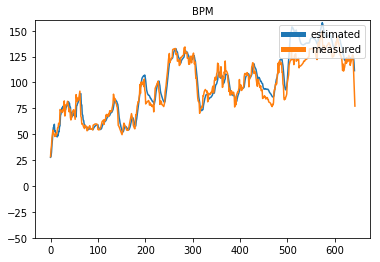

In [670]:
fig = plt.figure()

subplot1 = fig.add_subplot(111)
#subplot2 = fig.add_subplot(212)


subplot1.plot(est_x, label = 'estimated')
#subplot1.legend(handles=[red_patch])
#plt.legend(handles=[red_patch])


subplot1.set_title('BPM', fontsize = 10)

subplot1.plot(x_input[:], label = 'measured')
legend = subplot1.legend(loc='upper right')
subplot1.set_ylim([-50, 160])


# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
#frame = legend.get_frame()
#frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize(10)

for label in legend.get_lines():
    label.set_linewidth(5)  # the legend line width
plt.show()